![electronic_music_by_genre.jpg](src/img/electronic_music_by_genre.jpg)

# 0. PROBLEMA DE NEGOCIO

<b>Contexto del negocio:</b><br>
Somos un sello discográfico consolidado y reconocido por nuestra trayectoria en géneros de música tradicional (como folclore, jazz, blues y música regional). En respuesta a los cambios en el consumo musical global y el crecimiento de la música electrónica, la dirección del sello ha decidido explorar oportunidades de expansión hacia este nuevo mercado.<br>

<b>Desafío estratégico:</b><br>
A diferencia de los géneros tradicionales, la música electrónica presenta una estructura acústica diferente, con subgéneros menos delimitados, una producción digital más compleja, y una variedad de métricas poco conocidas para nuestro equipo curatorial. Antes de lanzar nuevas producciones o firmar artistas, necesitamos entender cómo se organiza, segmenta y comporta la música electrónica desde una perspectiva cuantitativa. 

<b>Objetivos del proyecto:</b><br>

- Exploración del espacio sonoro de la música electrónica mediante análisis exploratorio de datos (EDA) sobre un conjunto de canciones etiquetadas por género y representadas por características acústicas extraídas (como MFCCs, entropía espectral, BPM, etc.).<br>

- Desarrollo de un modelo de clasificación automática, que nos permita:<br>

  - Clasificar nuevas producciones o maquetas dentro de los subgéneros electrónicos predominantes.

  - Identificar si una canción electrónica tiene una estructura compatible con la línea editorial de nuestro sello (a través de distribuciones de características acústicas similares).

  - Automatizar el análisis curatorial de demos entrantes.

<b>Buscaremos tener rendimientos que superen el 80% del F-1 Score weighted</b><br>

<b>Valor para el negocio:</b><br>
Este sistema no solo acelera el proceso de exploración y filtrado de talento dentro del ámbito electrónico, sino que también reduce la incertidumbre creativa y comercial al permitirnos detectar automáticamente qué tipo de música electrónica se alinea con nuestras potenciales líneas editoriales.


Dataset: <a href="https://www.kaggle.com/datasets/caparrini/electronic-music-features-201611-beatporttop100">Electronic Music Features - 201611 BeatportTop100</a>
</p>


In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./src/utils') 
import bootcampviztools as bt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif,SelectFromModel, RFECV, SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import os
from IPython.display import display, Image
import sys
from sklearn.metrics import classification_report, accuracy_score,  make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import f_oneway
from sklearn.utils.class_weight import compute_sample_weight
from lightgbm import plot_importance
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import joblib

# 1. Carga datos

In [75]:
#Cargo el dataset
df = pd.read_csv('./src/data_sample.csv')

In [76]:
#Echo un primer vistazo
df.head()

Unnamed: 0    1-ZCRm  2-Energym  3-EnergyEntropym  4-SpectralCentroidm  \
0           0  0.136402   0.088891          3.201238             0.262813   
1           1  0.117053   0.108397          3.194091             0.247679   
2           2  0.085314   0.128537          3.123835             0.217220   
3           3  0.103046   0.167006          3.151050             0.233638   
4           4  0.151702   0.148412          3.194361             0.293711   

   5-SpectralSpreadm  6-SpectralEntropym  7-SpectralFluxm  8-SpectralRolloffm  \
0           0.249214            1.114200         0.007004            0.256620   
1           0.250297            1.065840         0.005388            0.199849   
2           0.228655            0.789821         0.008251            0.156863   
3           0.245044            0.967372         0.006569            0.168171   
4           0.267226            1.352688         0.003874            0.291922   

   9-MFCCs1m  ...  85-beats_loudness_band_ratio.mean5  \
0 -22.723397  ...                            0.053618   
1 -21.775519  ...                            0.077255   
2 -22.472499  ...                            0.052989   
3 -21.471472  ...                            0.059995   
4 -21.371298  ...                            0.062124   

   86-beats_loudness_band_ratio.mean6  87-beats_loudness_band_ratio.stdev1  \
0                            0.060700                             0.361006   
1                            0.070787                             0.345560   
2                            0.064381                             0.250985   
3                            0.046833                             0.316349   
4                            0.093716                             0.316923   

   88-beats_loudness_band_ratio.stdev2  89-beats_loudness_band_ratio.stdev3  \
0                             0.229552                             0.260985   
1                             0.106581                             0.198952   
2                             0.148319                             0.094546   
3                             0.119784                             0.092762   
4                             0.087055                             0.139083   

   90-beats_loudness_band_ratio.stdev4  91-beats_loudness_band_ratio.stdev5  \
0                             0.145522                             0.078291   
1                             0.095644                             0.100741   
2                             0.085440                             0.039289   
3                             0.110708                             0.079089   
4                             0.095219                             0.071245   

   92-beats_loudness_band_ratio.stdev6    class              id  
0                             0.082724  BigRoom  BigRoom001.wav  
1                             0.072654  BigRoom  BigRoom002.wav  
2                             0.062705  BigRoom  BigRoom003.wav  
3                             0.061871  BigRoom  BigRoom004.wav  
4                             0.095066  BigRoom  BigRoom005.wav  

[5 rows x 95 columns]

In [77]:
#Elimino las columnas que no me aportan nada
df.drop('id', axis = 1, inplace=True)
df.drop('Unnamed: 0', axis = 1, inplace=True)

# 2. Problema Machine Learning
Me encuentro frente a un problema de aprendizaje supervisado ya que cuento con datos etiquetados por genero. Me encuentro con un dataset con 95 variables y 2300 instancias. Donde cada instancia es un sample de 2 minutos de audio de 100 canciones por genero, del BeatportTop100 (Un canal de streaming y compra de canciones de musica electrónica), analizado técnicamente.

# 3. Divido en Train y Test

In [78]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [79]:
train_set.shape

(1840, 93)

In [80]:
test_set.shape

(460, 93)

# 4. Target

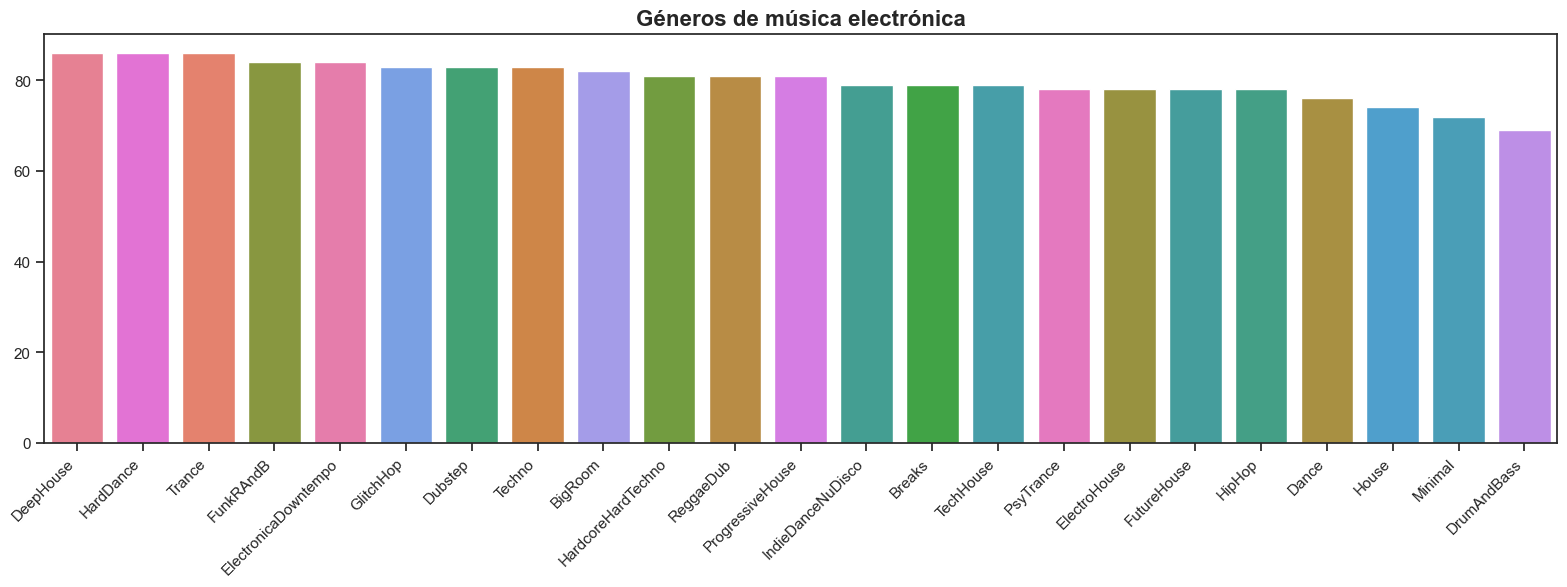

In [81]:
# Defino el target
target = 'class'

# Graficar
plt.figure(figsize=(16, 6))
sns.countplot(data=train_set, x=target, order=train_set[target].value_counts().index, legend=False, hue=target)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Título con tilde y negrita
plt.title('Géneros de música electrónica', fontsize=16, weight='bold')

# Quitar labels de los ejes
plt.xlabel("")
plt.ylabel("")

# Guardar la imagen
plt.savefig("./src/img/generos_musica_electronica.png", dpi=300, bbox_inches='tight')

# Mostrar en pantalla
plt.show()


Veo que me enfrento a un problema con un target balanceado y con muchisimas clases, en el EDA pasaréa agruparlas en su género principal según la imagen principal compartida y conocimiento de negocio

# 5. Comprensión de variables

In [82]:
#Miro de que tipo son los datos que dispongo
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1840 entries, 360 to 860
Data columns (total 93 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1-ZCRm                               1840 non-null   float64
 1   2-Energym                            1840 non-null   float64
 2   3-EnergyEntropym                     1840 non-null   float64
 3   4-SpectralCentroidm                  1840 non-null   float64
 4   5-SpectralSpreadm                    1840 non-null   float64
 5   6-SpectralEntropym                   1840 non-null   float64
 6   7-SpectralFluxm                      1840 non-null   float64
 7   8-SpectralRolloffm                   1840 non-null   float64
 8   9-MFCCs1m                            1840 non-null   float64
 9   10-MFCCs2m                           1840 non-null   float64
 10  11-MFCCs3m                           1840 non-null   float64
 11  12-MFCCs4m                        

<b>Me enfrento a un dataset únicamente con variables numéricas</b>

In [83]:
#Fuerzo el tipo de dato del que dispongo para evitar errores posteriores en train

new_types = {
    float: [col for col in train_set.columns if col not in ['class']],
    str: ['class'],
}

for key, value in new_types.items():
    for i in value:
        train_set[i] = train_set[i].astype(key)

#### Reporte de variables
Un pequeño reporte que incluye las características de las variables: el nombre, el tipo de dato, a que segmento se refiere la información, las expectativas de mantener la variable con un detalle de por qué y la conclusión preliminar.

In [84]:
feature_report = pd.read_excel('./src/analisis_variables_audio.xlsx')
feature_report

Variable  \
0                                1-ZCRm   
1                             2-Energym   
2                      3-EnergyEntropym   
3                   4-SpectralCentroidm   
4                     5-SpectralSpreadm   
..                                  ...   
87  88-beats_loudness_band_ratio.stdev2   
88  89-beats_loudness_band_ratio.stdev3   
89  90-beats_loudness_band_ratio.stdev4   
90  91-beats_loudness_band_ratio.stdev5   
91  92-beats_loudness_band_ratio.stdev6   

                                              Detalle              Data type  \
0   Zero Crossing Rate (media): cantidad de veces ...  cuantitativa continua   
1   Energy (media): energía total de la señal. Rel...  cuantitativa continua   
2   Energy Entropy (media): mide la variabilidad d...  cuantitativa continua   
3   Centroide espectral (media): indica el "centro...  cuantitativa continua   
4   Dispersión espectral (media): medida de cuán e...  cuantitativa continua   
..                                                ...                    ...   
87  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   
88  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   
89  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   
90  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   
91  Beat loudness 1 a 6 (desvío estándar): Energía...  cuantitativa continua   

                           Segmento Expectativas  \
0                 Espectral/Energía         Alta   
1                 Espectral/Energía         Alta   
2                 Espectral/Energía         Alta   
3                 Espectral/Energía         Alta   
4                 Espectral/Energía         Alta   
..                              ...          ...   
87  Banda de Frecuencias / Loudness        Media   
88  Banda de Frecuencias / Loudness        Media   
89  Banda de Frecuencias / Loudness        Media   
90  Banda de Frecuencias / Loudness        Media   
91  Banda de Frecuencias / Loudness        Media   

                                    Conclusiones  
0                     Probablemente se mantendrá  
1                     Probablemente se mantendrá  
2                     Probablemente se mantendrá  
3                     Probablemente se mantendrá  
4                     Probablemente se mantendrá  
..                                           ...  
87  Podría mantenerse si no hay alta correlación  
88  Podría mantenerse si no hay alta correlación  
89  Podría mantenerse si no hay alta correlación  
90  Podría mantenerse si no hay alta correlación  
91  Podría mantenerse si no hay alta correlación  

[92 rows x 6 columns]

<b>De este reporte, obtengo una primera separacion entre las expectativas que tengo de cada variable. Divido en alta, media y bajas o inciertas expectativas de quedarme con esta variable. Describo el tipo de variable, a que se estan refiriendo y detallo por que serian o no importante y que conclusion inicial puedo obtener. Al ser informacion tecnica de un sample de audio, entiendo que varias variables van a ser redundantes, me van a aportar la misma informacion. Incluso ya viendo los nombres y viendo que parecerian indicar caracteristicas similares de la misma cosa, puedo llegar a imaginarme que seran redundantes. Analizare en profundidad su colinealidad.</b>

<b>Hago una lista de estas variables con expectativas altas</b>

In [85]:
features_altas_expectativas = feature_report.loc[feature_report['Expectativas'] == 'Alta', 'Variable'].tolist()
features_altas_expectativas

['1-ZCRm',
 '2-Energym',
 '3-EnergyEntropym',
 '4-SpectralCentroidm',
 '5-SpectralSpreadm',
 '6-SpectralEntropym',
 '7-SpectralFluxm',
 '8-SpectralRolloffm',
 '9-MFCCs1m',
 '22-ChromaVector1m',
 '43-MFCCs1std',
 '56-ChromaVector1std',
 '69-BPM',
 '70-BPMconf',
 '71-BPMessentia',
 '77-danceability']

# EDA

##### Preguntas

1. ¿Es el House el género más bailable?
2. ¿Qué género musical presenta mayor energía o intensidad percibida?
3. ¿La música electrónica es puro ruido?
4. ¿Cómo diferenciamos los géneros?

##### Análisis

Siguiendo la siguiente imagen, utilizaremos los géneros madre para agrupar los subgéneros y así simplificar el análisis visual y gráfico del EDA.

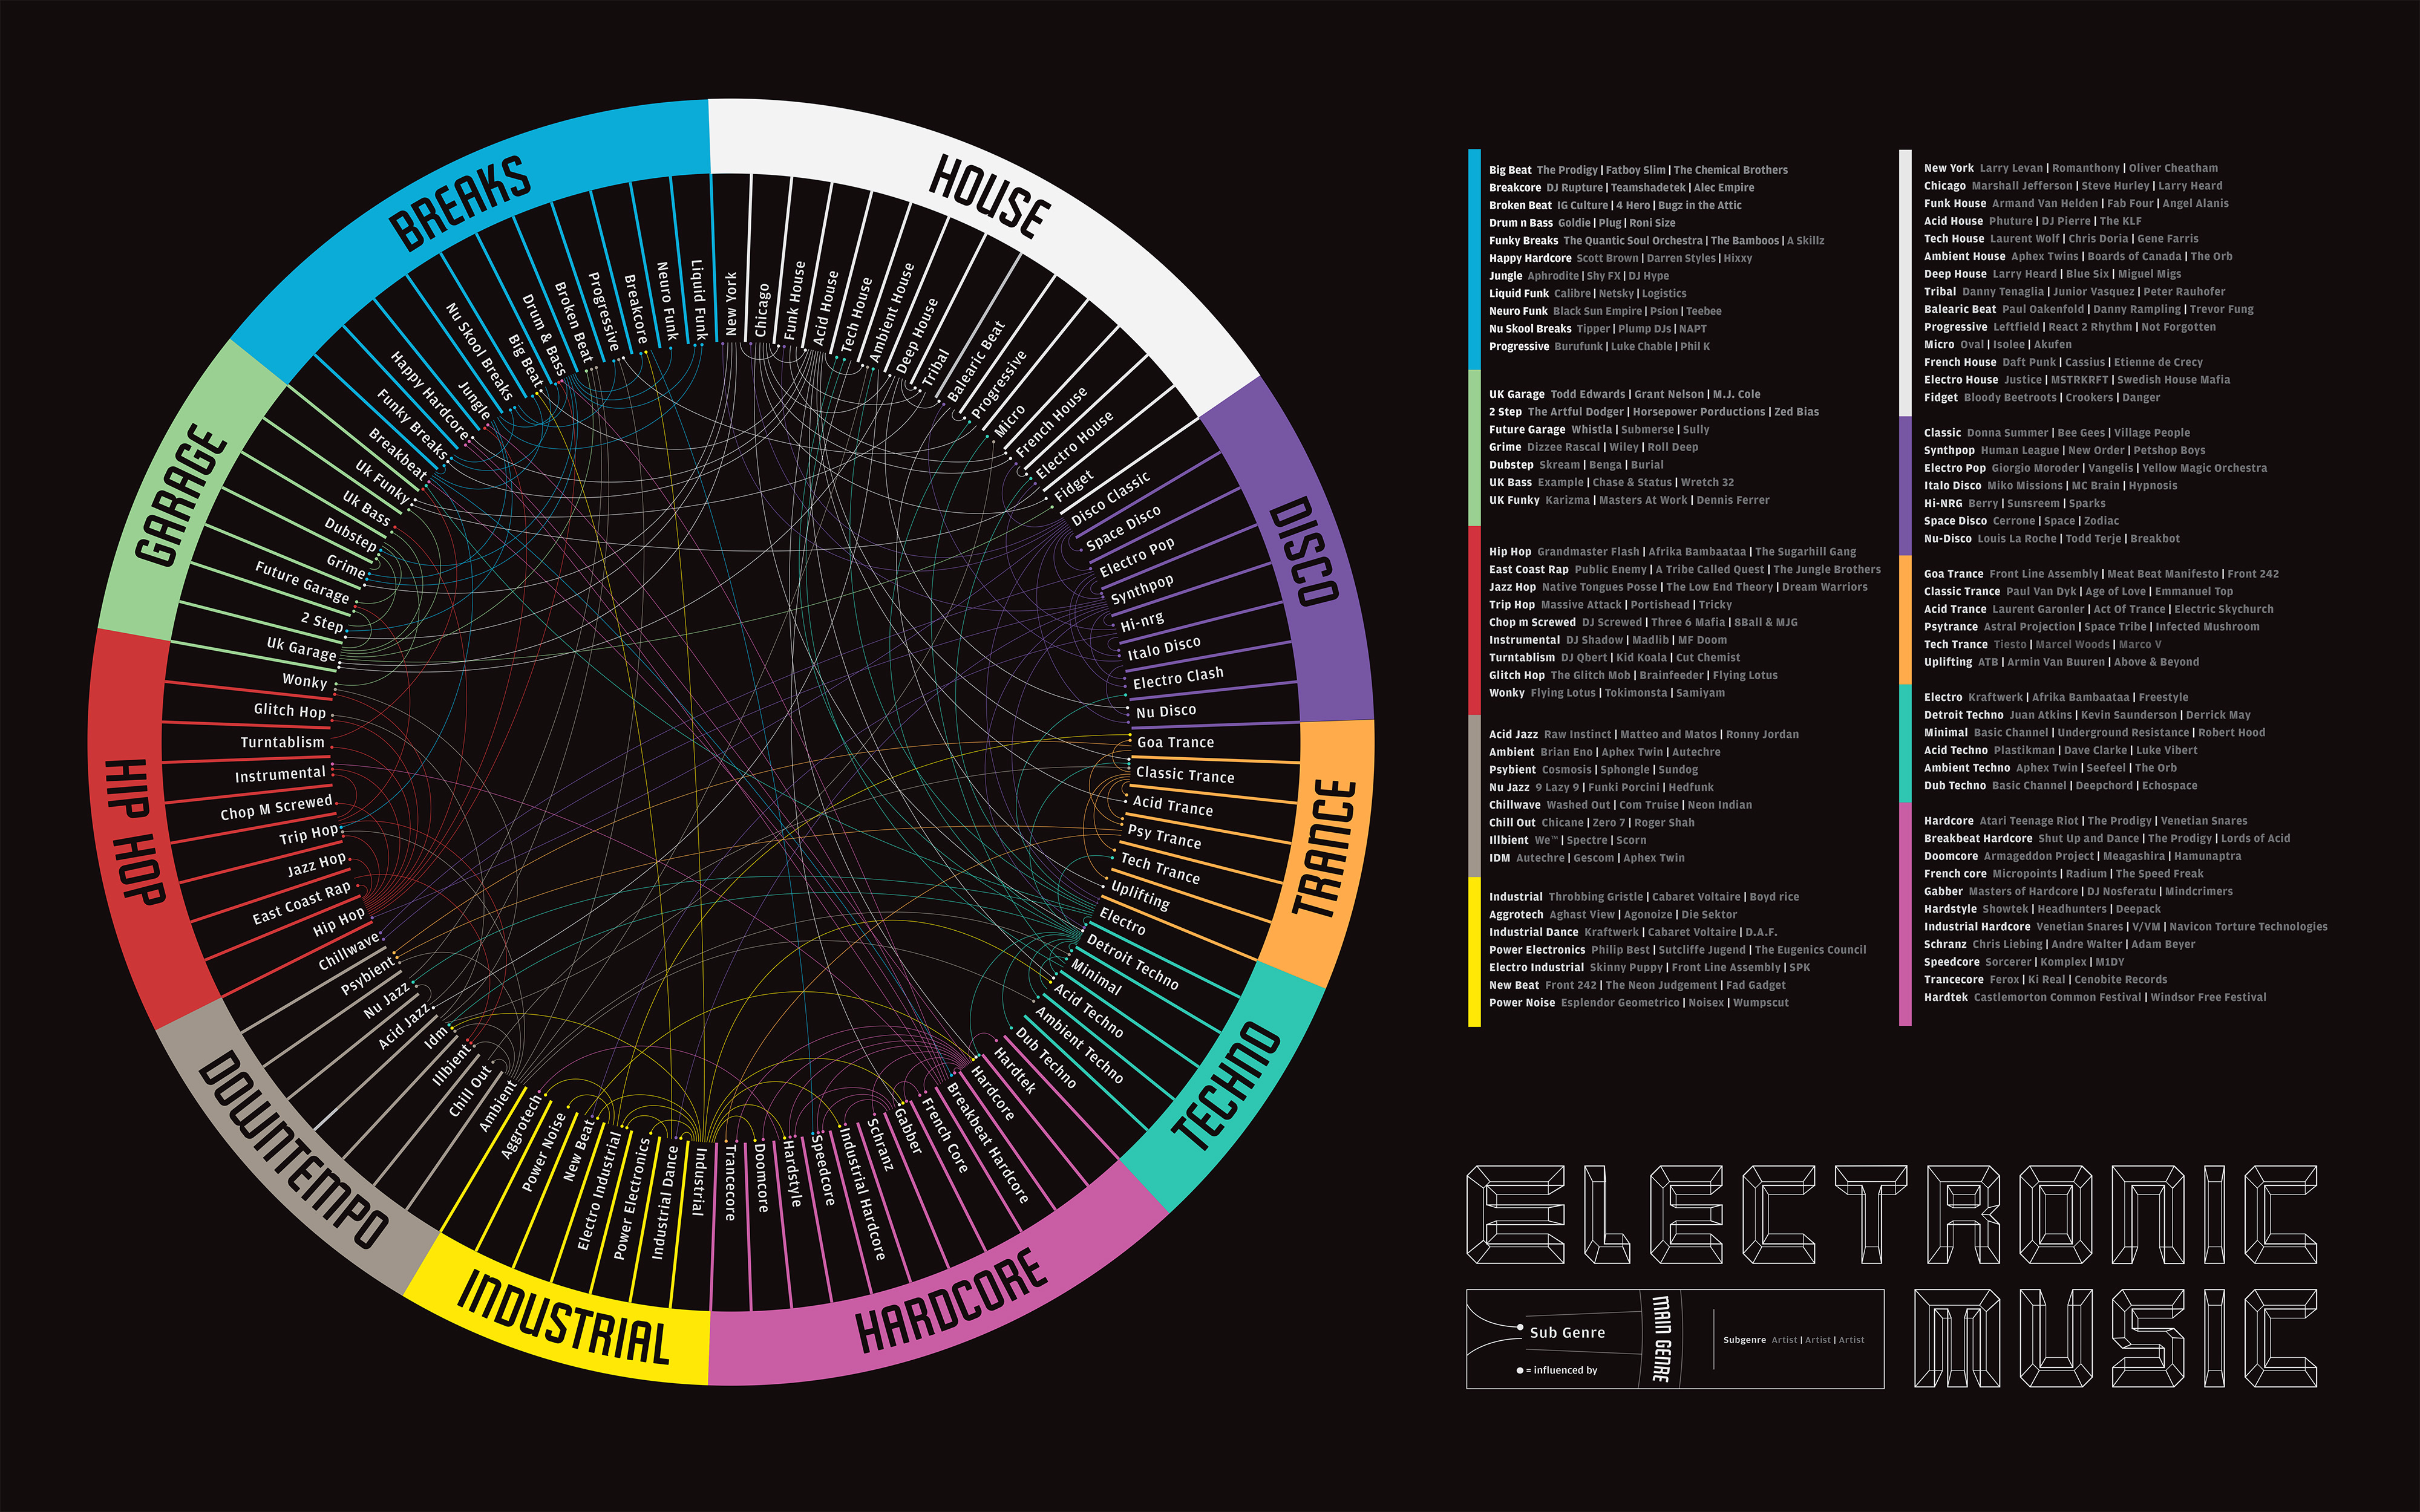

In [86]:
img = './src/img/electronic_music_by_genre.jpg'
display(Image(filename=img))

In [87]:
train_set[target].value_counts()

class
DeepHouse               86
HardDance               86
Trance                  86
FunkRAndB               84
ElectronicaDowntempo    84
GlitchHop               83
Dubstep                 83
Techno                  83
BigRoom                 82
HardcoreHardTechno      81
ReggaeDub               81
ProgressiveHouse        81
IndieDanceNuDisco       79
Breaks                  79
TechHouse               79
PsyTrance               78
ElectroHouse            78
FutureHouse             78
HipHop                  78
Dance                   76
House                   74
Minimal                 72
DrumAndBass             69
Name: count, dtype: int64

In [88]:
#Me aseguro que sean de tipo Str en train y test
train_set[target] = train_set[target].astype(str)
test_set[target] = test_set[target].astype(str)


In [89]:
#Me aseguro que no haya espacios al comienzo o al final de cada etiqueta
train_set[target] = train_set[target].str.strip().str.replace(" ", "")
test_set[target] = test_set[target].str.strip().str.replace(" ", "")

In [90]:
#Recategorizo las etiquetas siguiendo la imagen principal y con conocimiento de negocio en train y test

train_set['new_target'] = train_set[target].replace({'DeepHouse': 'House',
               'ProgressiveHouse': 'House',
               'TechHouse': 'House',
               'PsyTrance': 'Trance',
               'HardDance': 'Techno',
               'FunkRAndB': 'Urban',
                'ElectronicaDowntempo': 'Downtempo',
                'GlitchHop': 'Urban',
                'Dubstep': 'Garage',
                'BigRoom': 'House',
                'HardcoreHardTechno': 'Techno',
                'IndieDanceNuDisco': 'Disco',
                'ElectroHouse': 'House',
                'FutureHouse': 'House',
                'DrumAndBass': 'Urban',
                'Minimal': 'Techno',
                'Dance': 'House',
                'Hardcore': 'Techno',
                'HipHop': 'Urban',
                'Breaks': 'Urban',
                'ReggaeDub': 'Urban'})

test_set['new_target'] = test_set[target].replace({'DeepHouse': 'House',
               'ProgressiveHouse': 'House',
               'TechHouse': 'House',
               'PsyTrance': 'Trance',
               'HardDance': 'Techno',
               'FunkRAndB': 'Urban',
                'ElectronicaDowntempo': 'Downtempo',
                'GlitchHop': 'Urban',
                'Dubstep': 'Garage',
                'BigRoom': 'House',
                'HardcoreHardTechno': 'Techno',
                'IndieDanceNuDisco': 'Disco',
                'ElectroHouse': 'House',
                'FutureHouse': 'House',
                'DrumAndBass': 'Urban',
                'Minimal': 'Techno',
                'Dance': 'House',
                'Hardcore': 'Techno',
                'HipHop': 'Urban',
                'Breaks': 'Urban',
                'ReggaeDub': 'Urban'})




In [91]:
train_set['new_target'].value_counts()

new_target
House        634
Urban        474
Techno       322
Trance       164
Downtempo     84
Garage        83
Disco         79
Name: count, dtype: int64

Me aseguro que hayan quedado del mismo tamaño

In [92]:
train_set.shape

(1840, 94)

In [93]:
test_set.shape

(460, 94)

In [94]:
#Defino mi nuevo target
target = 'new_target'

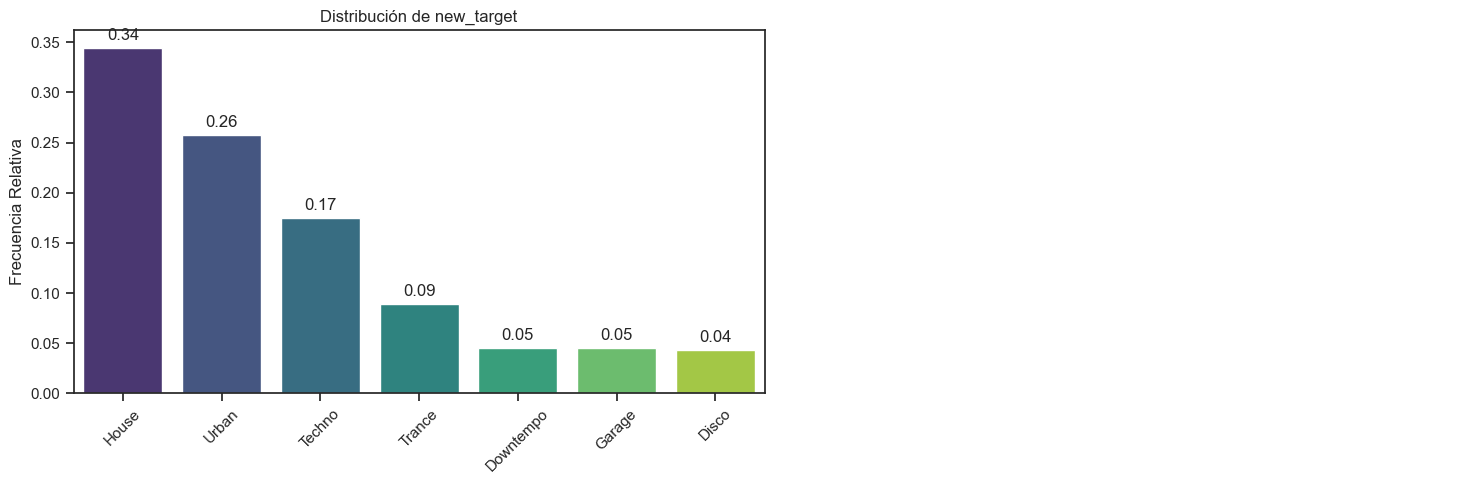

In [95]:
#Analizo el target
bt.pinta_distribucion_categoricas(train_set, columnas_categoricas=[target], mostrar_valores=True, relativa=True)

Vemos como al agrupar los subgéneros desbalancea el target. Luego utilizaremos las herramientas necesarias para equilibrarlo

In [96]:
#### Busco si hay valores nulos o valores 0 en las columnas
for col in train_set.columns:
    nulos = train_set[col].isnull().sum()
    ceros = (train_set[col] == 0).sum() if train_set[col].dtype != 'O' else 0
    if nulos > 0 or ceros > 0:
        print(f"Columna '{col}': {nulos} nulos, {ceros} ceros")

Columna '73-bpm_histogram_first_peak_weight': 0 nulos, 42 ceros
Columna '74-bpm_histogram_second_peak_bpm': 0 nulos, 125 ceros
Columna '75-bpm_histogram_second_peak_spread': 0 nulos, 768 ceros
Columna '76-bpm_histogram_second_peak_weight': 0 nulos, 125 ceros


Contexto de negocio para estas columnas:
Estas columnas son  derivadas de un análisis de histograma del tempo (BPM). Usualmente, en audio: el primer pico se refiere al BPM más probable.
El segundo pico representa un BPM alternativo, si existe.
Esto sugiere que cuando el segundo pico no existe (no se detecta otro BPM relevante), es esperado que second_peak_bpm, second_peak_weight, etc. sean 0.
Así que no son valores faltantes, sino ausencia legítima de una segunda modalidad en el histograma. Justo estas columnas son las columnas que apriori estan etiquetadas con una baja expectativa de mantenerlas.

Analizo primero las 3 variables que hacen referencia al tempo, ya que por conocimiento de negocio, sé que es uno de los factores principales de diferenciación de género.

In [97]:
#Observo que valores tiene
train_set['69-BPM'].value_counts()

69-BPM
120.000000    658
133.333333    494
150.000000    189
171.428571    159
240.000000    116
200.000000     99
109.090909     53
300.000000     41
100.000000     12
400.000000      7
92.307692       4
600.000000      3
85.714286       3
63.157895       1
80.000000       1
Name: count, dtype: int64

In [98]:
#Observo que valores tiene
train_set['70-BPMconf'].value_counts()

70-BPMconf
0.113648    3
0.168038    2
0.293719    2
0.200000    2
0.103385    2
           ..
0.114948    1
0.192281    1
0.161808    1
0.119306    1
0.149327    1
Name: count, Length: 1830, dtype: int64

In [99]:
#Observo que valores tiene
train_set['71-BPMessentia'].value_counts()

71-BPMessentia
172.265961    5
172.265839    4
128.020706    3
128.096390    2
123.981453    2
             ..
125.933182    1
128.093826    1
139.801910    1
128.238403    1
111.970833    1
Name: count, Length: 1806, dtype: int64

Luego de revisar los valores para cada variable, me doy cuenta de que los valores de '69-BPM' no me hacen sentido conociendo el negocio. Esta columna me doy cuenta de que tiene valores muy discretos y repetidos, y valores extremos como 300, 400 o 600. No parecen mediciones exactas sino valores normalizados o redondeados automaticamente. Y luego al analizar los valores de la columna '71-BPMessentia' me doy cuenta de que esta es la que contiene la informacion real, medida por Essentia, una librería especializada en análisis de audio. Entonces decido utilizar la feature '71-BPMessentia' como mi variable principal de tempo y elimino la variable '69-BPM' que se a ciencia exacta que no colabora con mi modelo y '70-BPMconf' se refiere a la confianza en la variable '69-BPM, la descarto tambien

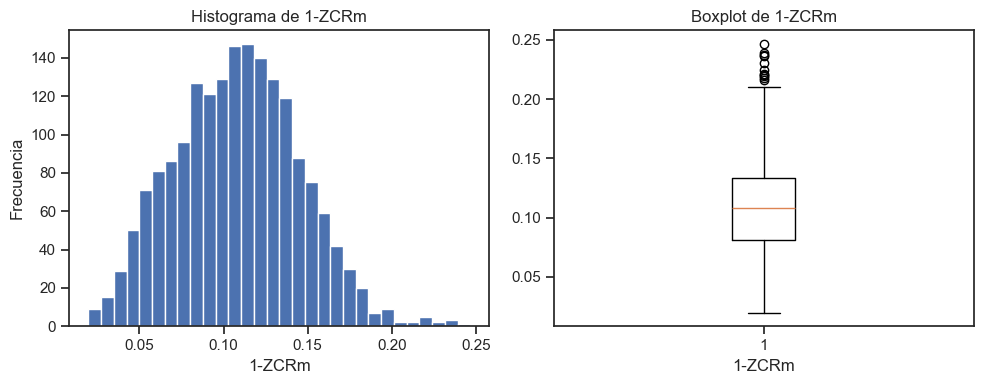

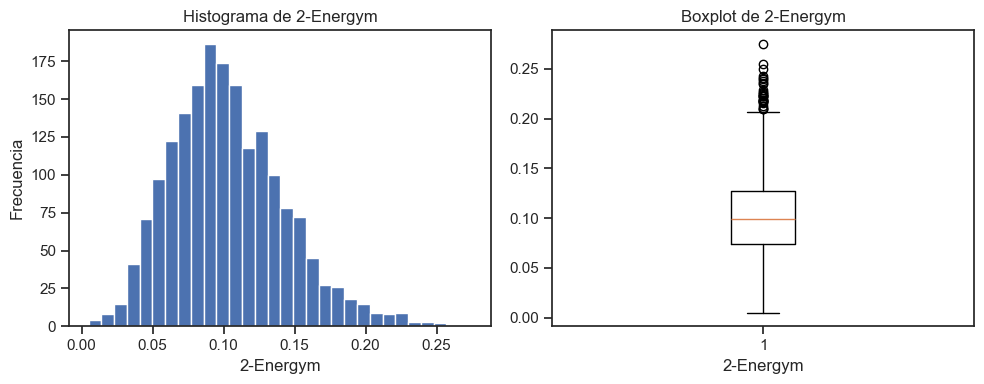

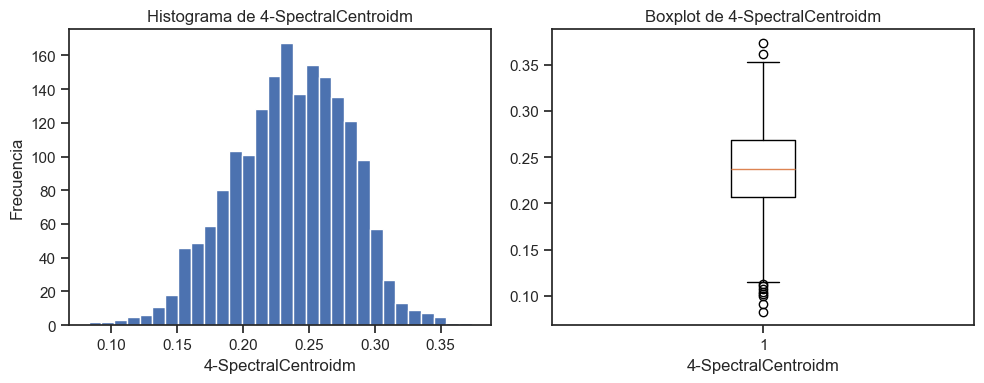

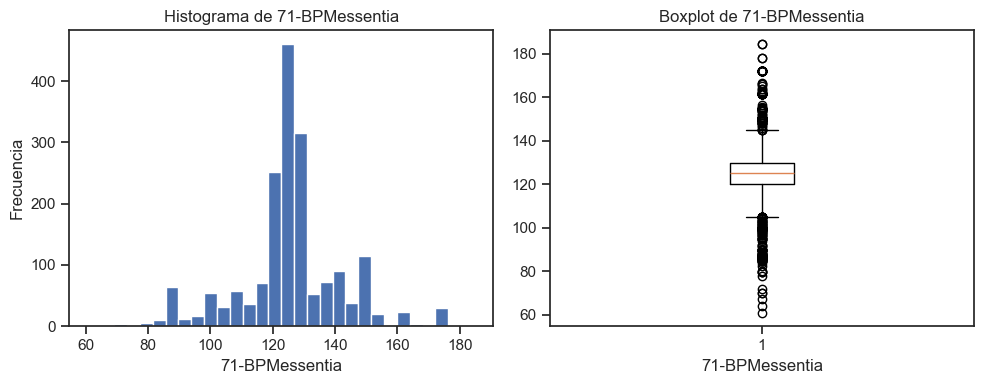

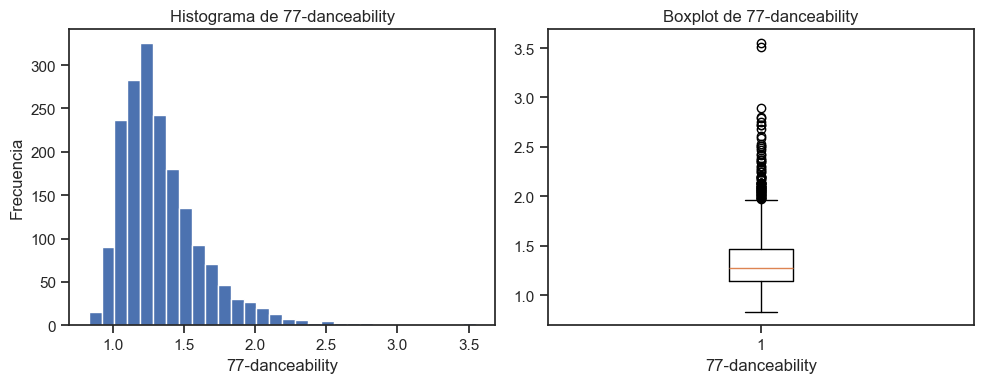

In [100]:
# Seleccionar algunas variables representativas para visualización
selected_columns = [
    '1-ZCRm',             # Zero Crossing Rate media
    '2-Energym',          # Energía media
    '4-SpectralCentroidm',# Centroide espectral medio
    '71-BPMessentia',     # Beats por minuto
    '77-danceability'     # Bailabilidad
]

# Crear histogramas y boxplots para cada variable
for col in selected_columns:
    plt.figure(figsize=(10, 4))

    # Histograma
    plt.subplot(1, 2, 1)
    plt.hist(train_set[col], bins=30)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(train_set[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

Al hacer una búsqueda visual de un primer set de variables importantes, me ecuentro con que todas son informativas y me encuentro con multiples outliers en 77-danceability y BPMessentia. Voy a buscar a que géneros pertenecen, estimo que a géneros más intensos.

In [101]:
train_set.loc[train_set['77-danceability']>2]['new_target'].value_counts()

new_target
House        19
Disco        18
Urban        17
Downtempo     8
Techno        7
Name: count, dtype: int64

Valores altos (~3 o más) indican que el tema tiene: Un patrón rítmico muy regular, un alto grado de repetitividad y beats bien definidos. Aunque, la variable combina el tempo, la energia y la estabilidad rítmica, todas características expresadas por otras variables. Luego cuando analice la correlación, evaluaré su importancia. 

El BPM representa el tempo de la canción, es normal que haya Outliers, ya que este valor es muy amplio, puede ir desde 60 a 240 dependiendo del género, aunque analizare si hay algun valor extraño para cada género, teniendo en cuenta el modelo de negocio y los standares

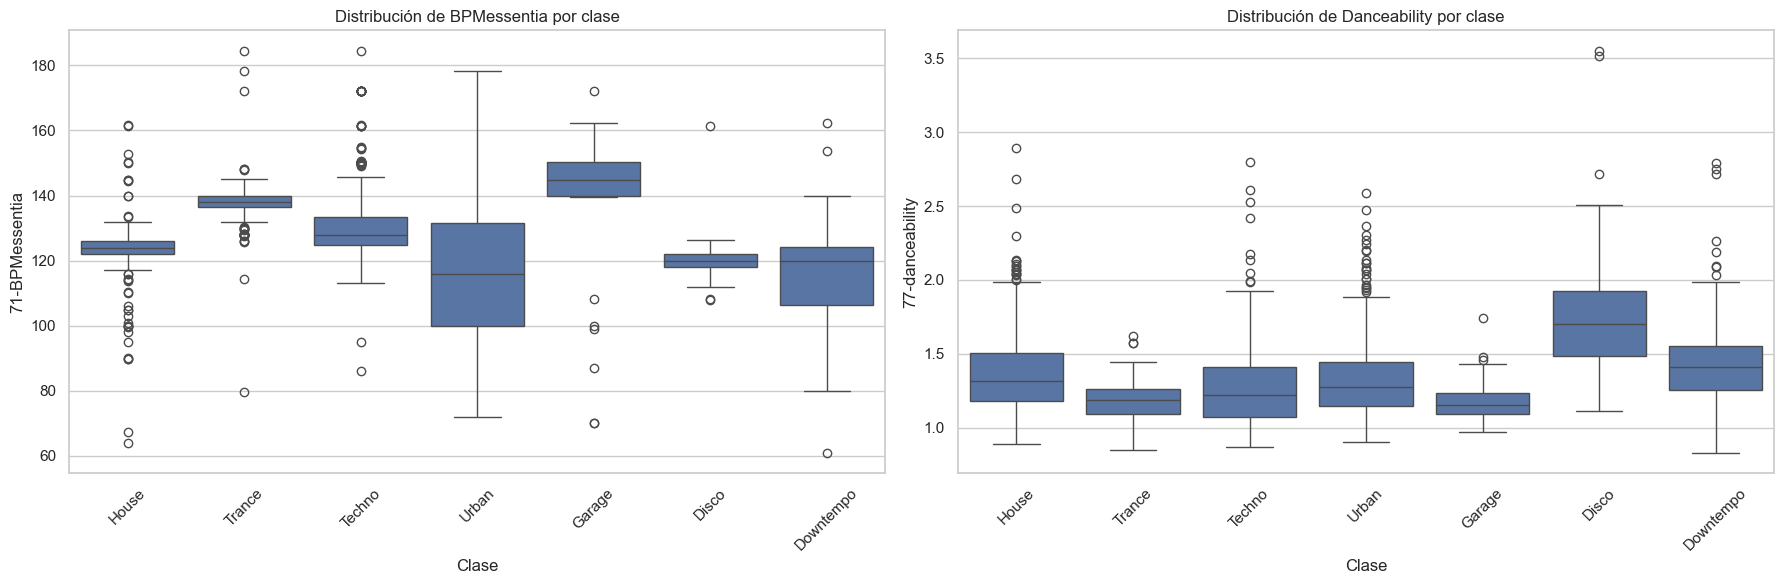

In [102]:
# Establecer estilo de gráfico
sns.set(style="whitegrid")

# Crear boxplots de BPMessentia y danceability por clase
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# BPMessentia por clase
sns.boxplot(data=train_set, x='new_target', y='71-BPMessentia', ax=axes[0])
axes[0].set_title("Distribución de BPMessentia por clase")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("71-BPMessentia")
axes[0].tick_params(axis='x', rotation=45)

# Danceability por clase
sns.boxplot(data=train_set, x='new_target', y='77-danceability', ax=axes[1])
axes[1].set_title("Distribución de Danceability por clase")
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("77-danceability")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Observaciones para 'BPMessentia':

- Trance y Techno: tienen BPM altos y consistentes (medianas cerca de 135-140), con poca variabilidad, géneros rápidos y estables.
- Garage y House: también muestran BPM altos, pero con más dispersión en House.
- Urban: tiene una mediana más baja (~110) y una distribución más amplia, reflejando la diversidad del género (incluye HipHop, Funk, Reggae...).
- Downtempo: BPM significativamente más bajo (~100), como es esperable.
- Disco: mediana algo menor que House, pero menos variable.

Observo Outliers que me alarman, viendo valores muy bajos para Garage, Trance y Techno, los analizo mas adelante<br>
71-BPMessentia es altamente discriminante por clase. Podría ser muy útil para clasificación basada en tempo.

Oservaciones para 'danceability':

- Disco y Downtempo tienen las medianas más altas en bailabilidad,patrones rítmicos más predecibles o repetitivos.
- Urban muestra alta dispersión, probablemente por la mezcla de estilos dentro de esta clase.
- Trance y Techno tienen valores de danceability más bajos en promedio, pese a su ritmo acelerado (esto es coherente: rápido no siempre es bailable).
- Garage tiene valores más bajos y menos dispersión.

Muestra tendendias que pueden ayudarme a difenrenciar los grupos.

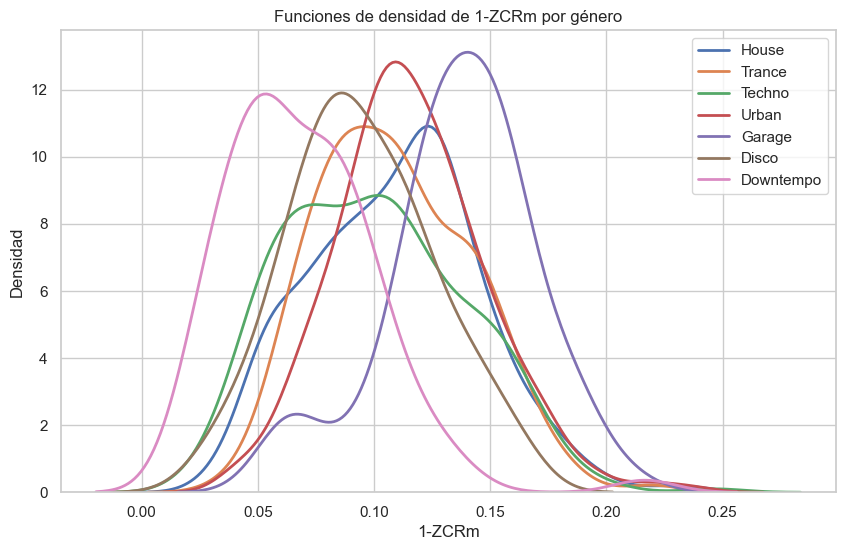

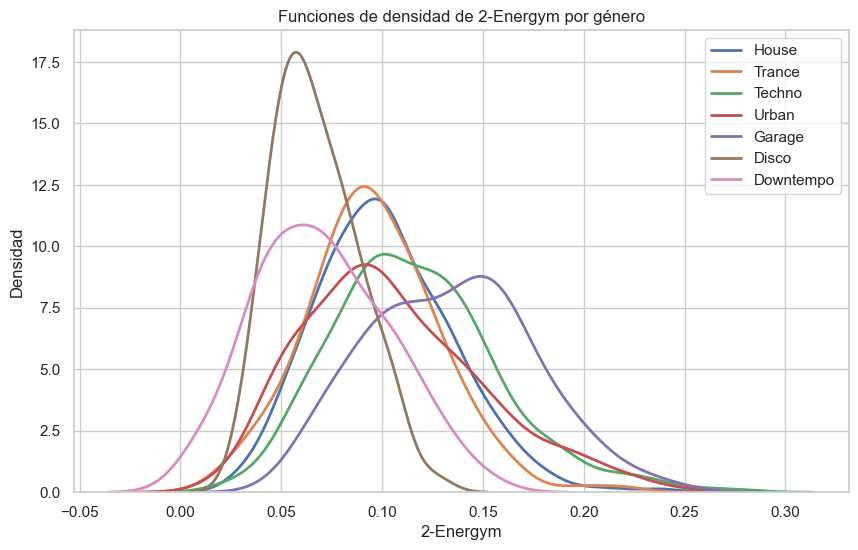

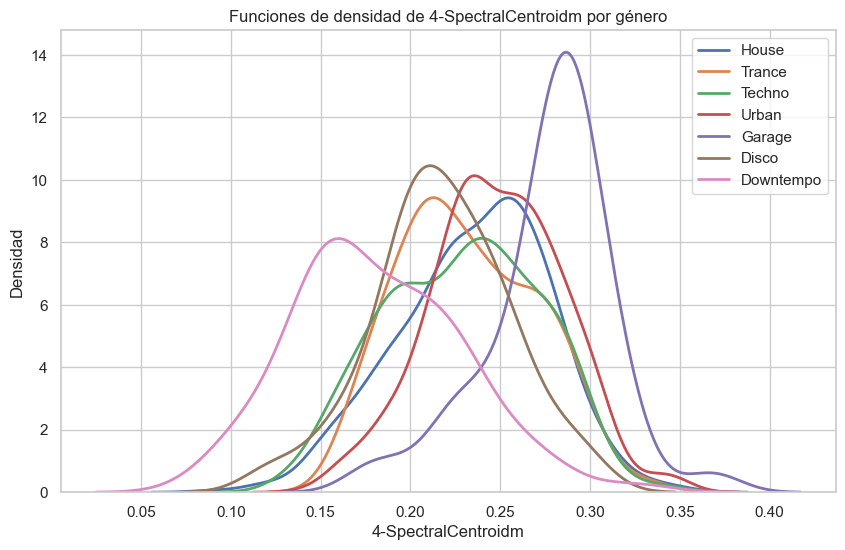

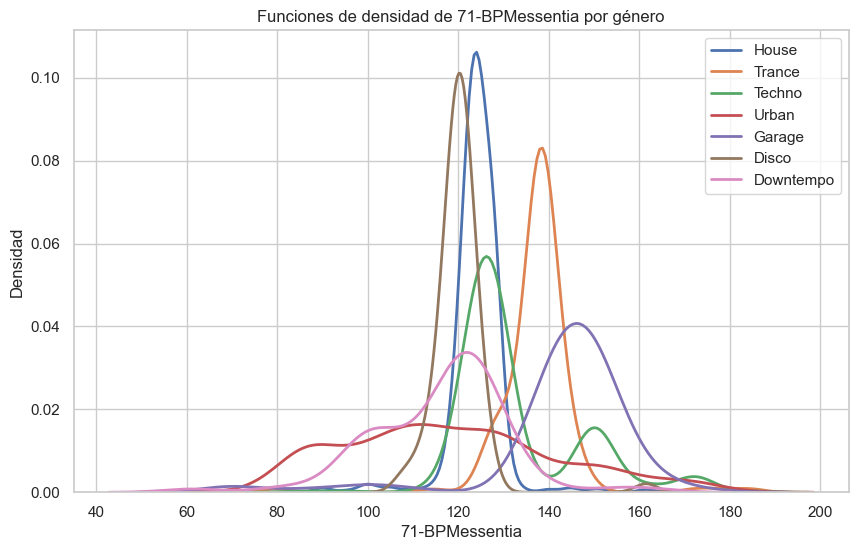

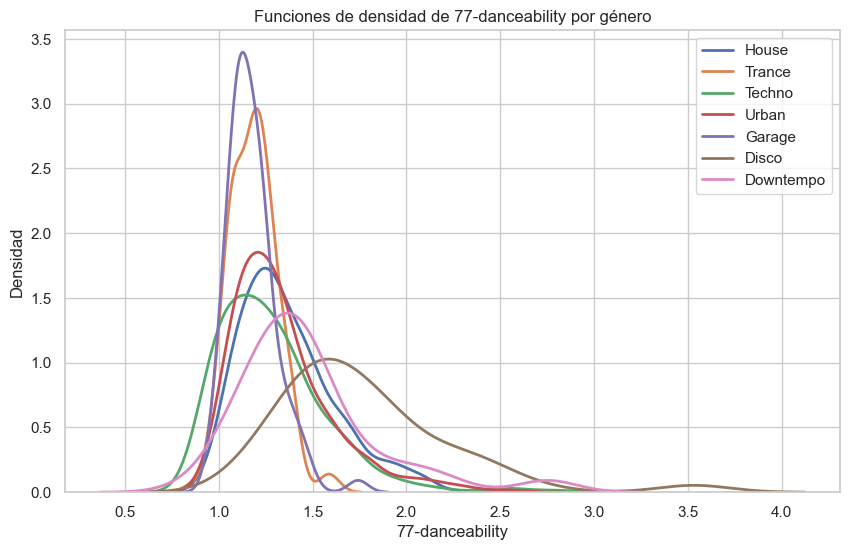

In [103]:
selected_variables = ['1-ZCRm', '2-Energym', '4-SpectralCentroidm', '71-BPMessentia', '77-danceability']

for var in selected_variables:
    plt.figure(figsize=(10, 6))
    for clase in train_set['new_target'].unique():
        sns.kdeplot(
            data=train_set[train_set['new_target'] == clase],
            x=var,
            label=clase,
            linewidth=2
        )
    plt.title(f'Funciones de densidad de {var} por género')
    plt.xlabel(var)
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()


In [104]:
selected_columns

['1-ZCRm',
 '2-Energym',
 '4-SpectralCentroidm',
 '71-BPMessentia',
 '77-danceability']

Todas aportan información valiosa para distinguir el género, pero veo que en '2-Energym', '4-SpectralCentroidm', '77-danceability' hay algunas funciones que se superponen y no hay desplazamientos tan marcados como en '1-ZCRm' y '71-BPMessentia'

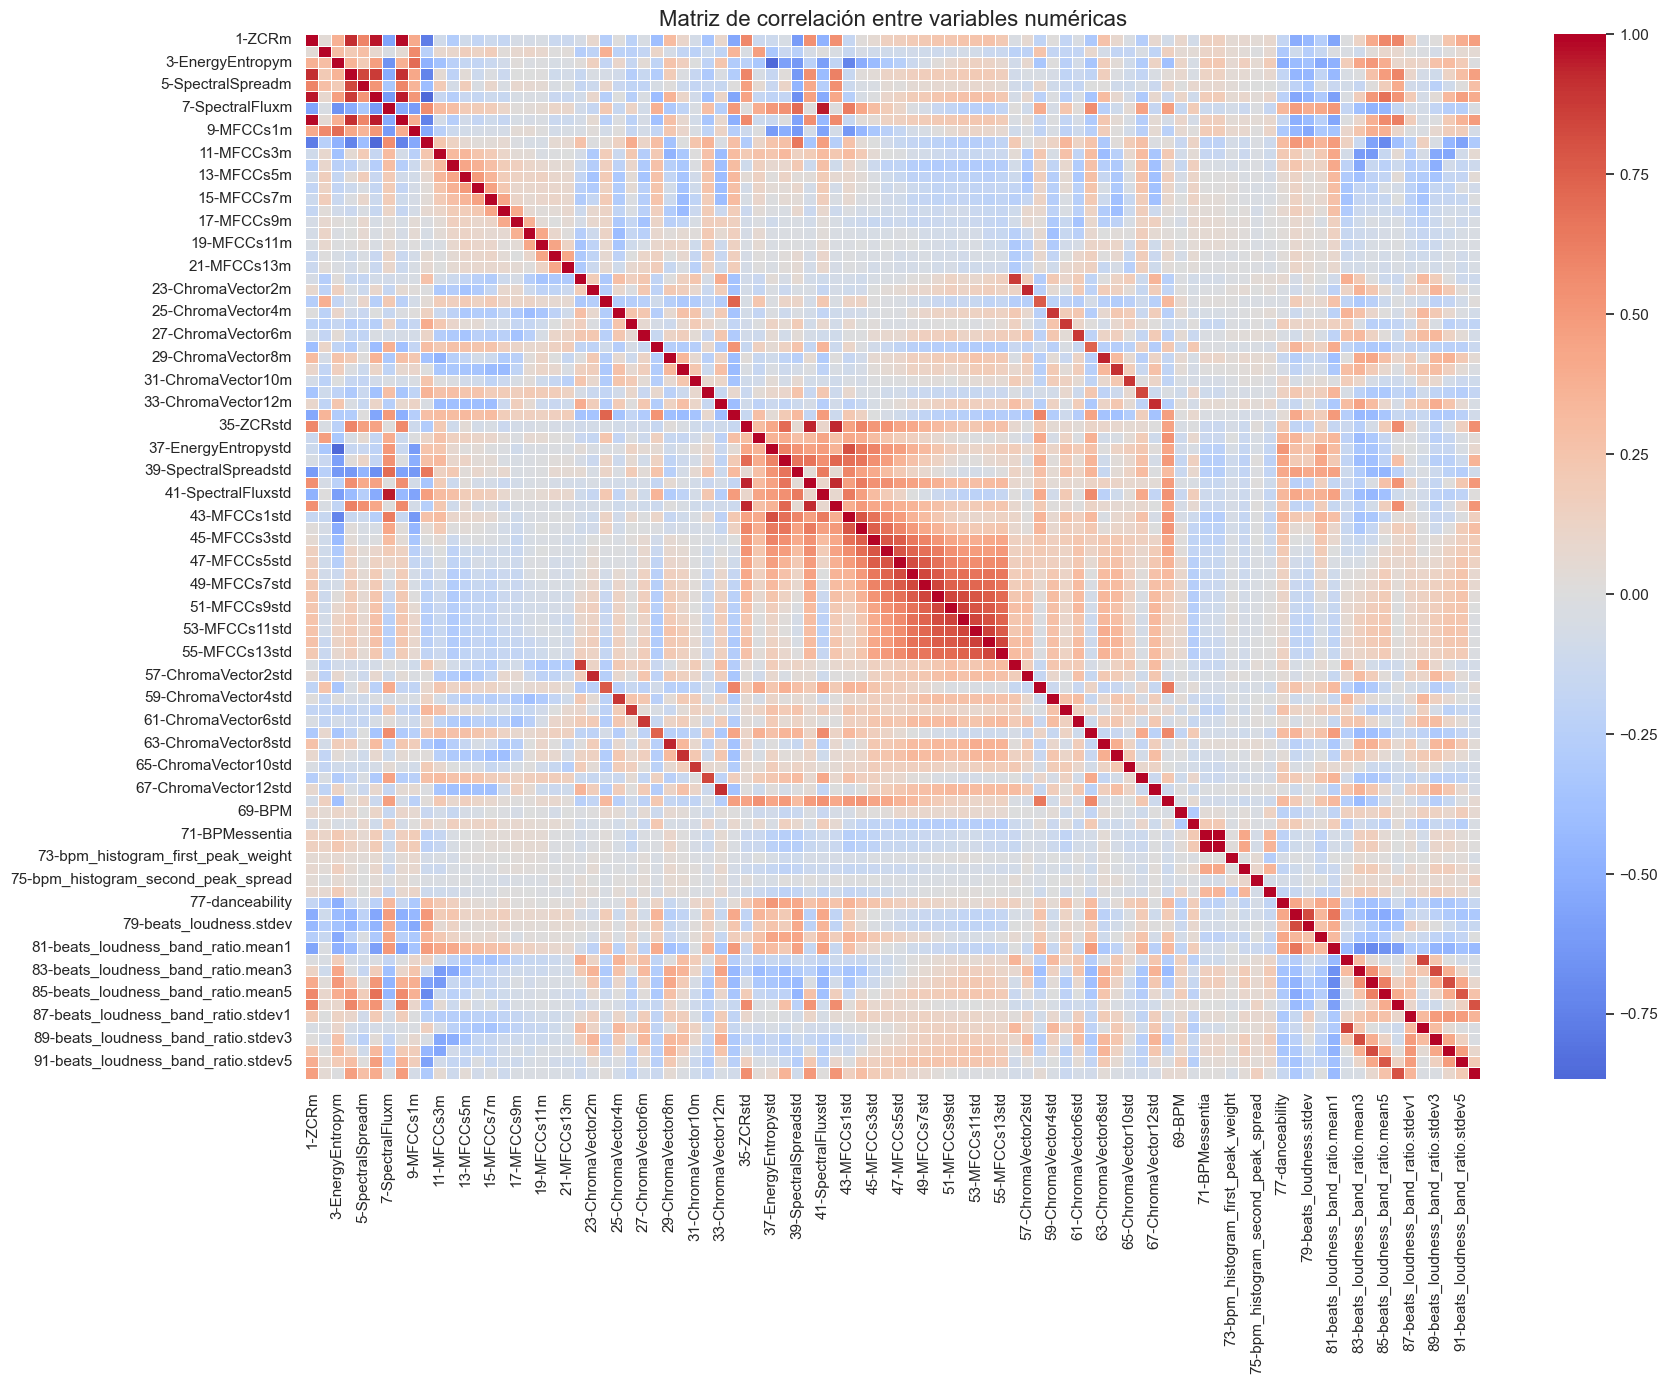

In [105]:

# Filtrar solo las columnas numéricas para calcular la matriz de correlación

numeric_df = train_set.drop(['class', 'new_target'], axis=1)
correlation_matrix = numeric_df.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Matriz de correlación entre variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()

Si bien son muchisimas variables como para entrar en detalle en un grafico así, igualmente podemos ver que hay variables con una correlación extrema, seguimos buscando.

Confirmamos lo que intuía, obsvervo correlaciones fuertes positivas entre columnas del mismo tipo:
- MFCCs medios (9–21) y sus correspondientes stds (43–55)
- ChromaVector medios y stds (22–34 vs. 56–68)
- beats_loudness_band_ratio.mean# con sus respectivas stdev#

Por otro lado:
- 77-danceability y 71-BPMessentia tienen correlaciones moderadas con varias otras métricas rítmicas y energéticas.
- 69-BPM, 72-bpm_histogram_first_peak_bpm y 71-BPMessentia están correlacionadas, como era esperable.

Para limpiar un poco el ruido, y teniendo en cuenta que cuento con múltiples variables que se refieren al mismo aspecto del sample de audio, voy a agrupar mis variables

In [106]:
features = train_set.drop(['class', 'new_target'], axis=1)

In [107]:
# Agrupar columnas por tipo de feature
groups = {
    'ZCR': [col for col in features if 'ZCR' in col],
    'Energy': [col for col in features if 'Energy' in col],
    'Spectral': [col for col in features if 'Spectral' in col],
    'MFCCs': [col for col in features if 'MFCCs' in col],
    'Chroma': [col for col in features if 'ChromaVector' in col or 'ChromaDeviation' in col],
    'BPM': [col for col in features if 'BPM' in col or 'onset_rate' in col or 'bpm' in col],
    'Beats Loudness': [col for col in features if 'beats_loudness' in col],
    'Danceability': [col for col in features if 'danceability' in col],
    'Otros': [col for col in features if col not in (
        ['class', 'id'] +
        [v for sublist in [
            [col for col in features if 'ZCR' in col],
            [col for col in features if 'Energy' in col],
            [col for col in features if 'Spectral' in col],
            [col for col in features if 'MFCCs' in col],
            [col for col in features if 'ChromaVector' in col or 'ChromaDeviation' in col],
            [col for col in features if 'BPM' in col or 'onset_rate' in col or 'bpm' in col],
            [col for col in features if 'beats_loudness' in col],
            [col for col in features if 'danceability' in col],
        ] for v in sublist]
    )]
}

In [108]:
groups


{'ZCR': ['1-ZCRm', '35-ZCRstd'],
 'Energy': ['2-Energym',
  '3-EnergyEntropym',
  '36-Energystd',
  '37-EnergyEntropystd'],
 'Spectral': ['4-SpectralCentroidm',
  '5-SpectralSpreadm',
  '6-SpectralEntropym',
  '7-SpectralFluxm',
  '8-SpectralRolloffm',
  '38-SpectralCentroidstd',
  '39-SpectralSpreadstd',
  '40-SpectralEntropystd',
  '41-SpectralFluxstd',
  '42-SpectralRolloffstd'],
 'MFCCs': ['9-MFCCs1m',
  '10-MFCCs2m',
  '11-MFCCs3m',
  '12-MFCCs4m',
  '13-MFCCs5m',
  '14-MFCCs6m',
  '15-MFCCs7m',
  '16-MFCCs8m',
  '17-MFCCs9m',
  '18-MFCCs10m',
  '19-MFCCs11m',
  '20-MFCCs12m',
  '21-MFCCs13m',
  '43-MFCCs1std',
  '44-MFCCs2std',
  '45-MFCCs3std',
  '46-MFCCs4std',
  '47-MFCCs5std',
  '48-MFCCs6std',
  '49-MFCCs7std',
  '50-MFCCs8std',
  '51-MFCCs9std',
  '52-MFCCs10std',
  '53-MFCCs11std',
  '54-MFCCs12std',
  '55-MFCCs13std'],
 'Chroma': ['22-ChromaVector1m',
  '23-ChromaVector2m',
  '24-ChromaVector3m',
  '25-ChromaVector4m',
  '26-ChromaVector5m',
  '27-ChromaVector6m',
  '28-C

Una vez tengo ya las variables divididas en grupo por características de sonido, paso a realizar un test estadístico para filtrar por las que mayor relevancia tienen y continuar el análisis.

In [109]:
# Ejecutar ANOVA para cada grupo y encontrar la variable más significativa
anova_results = {}

for group_name, columns in groups.items():
    p_values = {}
    for col in columns:
        try:
            groups_data = [train_set[train_set['new_target'] == cls][col] for cls in train_set['new_target'].unique()]
            f_stat, p_val = f_oneway(*groups_data)
            p_values[col] = p_val
        except:
            continue  # En caso de error (ej. columnas con valores constantes)
    
    # Ordenar por menor p-valor y guardar la más significativa
    if p_values:
        best_col = min(p_values, key=p_values.get)
        anova_results[group_name] = {
            'best_feature': best_col,
            'p_value': p_values[best_col]
        }

# Convertir a DataFrame para mostrar
anova_df = pd.DataFrame(anova_results).T.sort_values(by='p_value')
anova_df

best_feature p_value
MFCCs                     48-MFCCs6std     0.0
BPM                         70-BPMconf     0.0
Spectral         40-SpectralEntropystd     0.0
ZCR                          35-ZCRstd     0.0
Danceability           77-danceability     0.0
Energy             37-EnergyEntropystd     0.0
Beats Loudness  78-beats_loudness.mean     0.0
Chroma               28-ChromaVector7m     0.0

Aquí tengo una selección a partir de un método estadístico de las features que voy a analizar. Si bien el test me selecciono para el grupo de BPM '70-BPMconf', por conocimiento de negocio esa la voy a descartar y voy a quedarme con la que había elegido inicialmente que era '71-BPMessentia'

In [110]:
selected_features = [
    '48-MFCCs6std',
    '71-BPMessentia',
    '40-SpectralEntropystd',
    '35-ZCRstd',
    '77-danceability',
    '37-EnergyEntropystd',
    '78-beats_loudness.mean',
    '28-ChromaVector7m'
]

In [111]:
#Analizo los valores de BPM por genero
train_set.groupby('new_target')['71-BPMessentia'].describe()

count        mean        std         min         25%         50%  \
new_target                                                                     
Disco        79.0  120.214864   5.933308  107.985764  117.986137  120.024673   
Downtempo    84.0  116.175462  14.726028   60.963341  106.309689  119.996239   
Garage       83.0  142.836604  16.795116   69.972511  140.022057  144.903656   
House       634.0  123.941752   6.757330   63.974220  122.078251  123.971916   
Techno      322.0  132.879833  13.812836   86.017105  124.955805  127.983456   
Trance      164.0  137.686653   8.644252   79.623276  136.474342  137.926003   
Urban       474.0  118.299761  23.197384   72.108147  100.019081  115.997669   

                   75%         max  
new_target                          
Disco       122.077038  161.499008  
Downtempo   124.265150  162.367203  
Garage      150.184715  172.265747  
House       126.136183  161.694656  
Techno      133.511276  184.570297  
Trance      139.938461  184.570206  
Urban       131.580307  178.205811

In [112]:
train_set.loc[train_set['new_target'] == 'Downtempo', '71-BPMessentia'].describe()

count     84.000000
mean     116.175462
std       14.726028
min       60.963341
25%      106.309689
50%      119.996239
75%      124.265150
max      162.367203
Name: 71-BPMessentia, dtype: float64

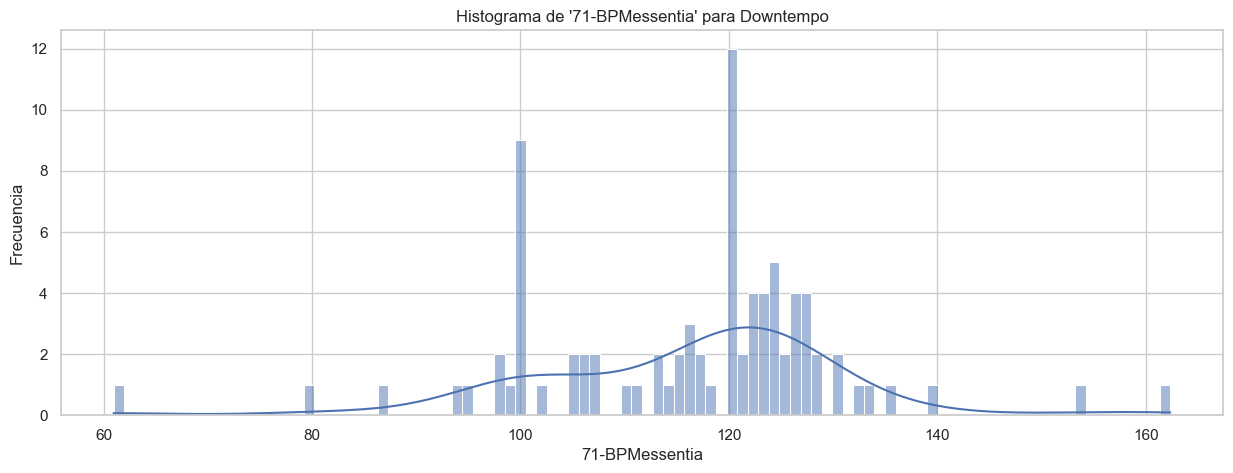

In [113]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Downtempo', '71-BPMessentia'], bins=100, kde=True)
plt.title("Histograma de '71-BPMessentia' para Downtempo")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

Por conocimiento de negocio, y al ver los valores de '71-BPMessentia' para Downtempo me encuentro con valores raros. En la producción de canciones de Downtempo muchas veces se utiliza un bpm de produccion duplicado, pero la cancion igualmente se encuentra a una velocidad baja. Es decir, técnicamente mi canción puede estar a una velocidad de 120bpm pero su composición y velocidad real es a 60bpm. Es por esto que voy a pasar a dividir a la mitad los valores que se encuentren por encima de 110. 

In [114]:
mask = (train_set['new_target'] == 'Downtempo') & (train_set['71-BPMessentia'] > 110)
train_set.loc[mask, '71-BPMessentia'] = train_set.loc[mask, '71-BPMessentia'] / 2

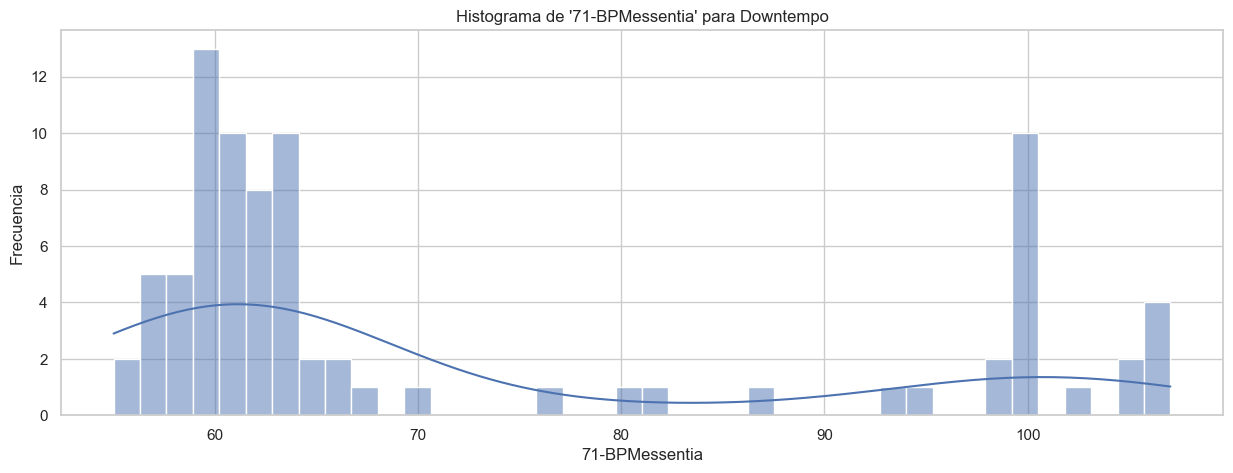

In [115]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Downtempo', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Downtempo")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

Esta distribución tiene muchísimo más sentido, continúo analizando 'Disco' que entiendo tiene un Outlier en 160

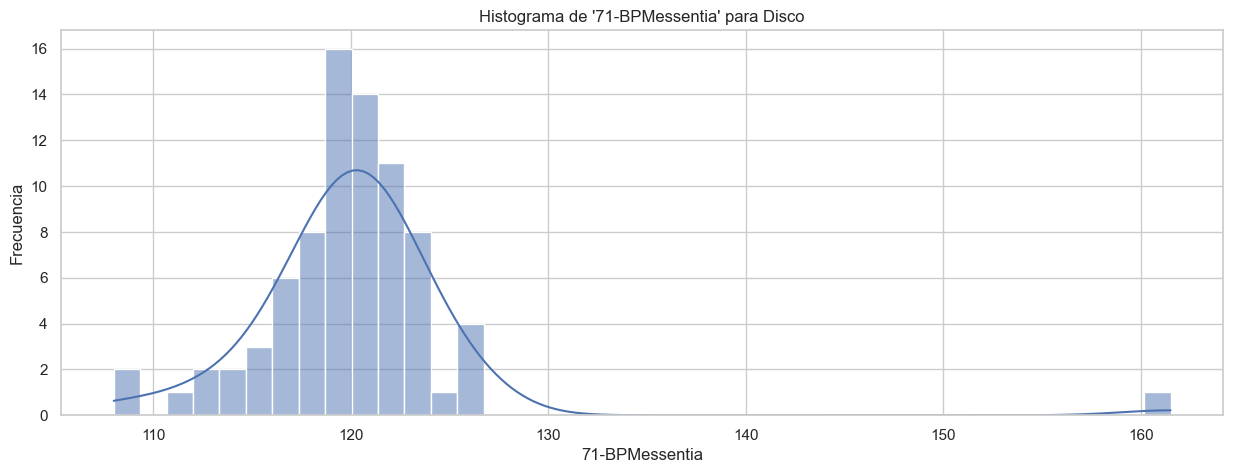

In [116]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Disco', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Disco")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

In [117]:
# Muestra los valores altos de BPM en 'Disco'
disco_high_bpm = train_set[(train_set['new_target'] == 'Disco') & (train_set['71-BPMessentia'] > 130)]
disco_high_bpm


1-ZCRm  2-Energym  3-EnergyEntropym  4-SpectralCentroidm  \
1527  0.054742   0.040127          3.141649             0.152411   

      5-SpectralSpreadm  6-SpectralEntropym  7-SpectralFluxm  \
1527            0.19017            0.490759         0.007331   

      8-SpectralRolloffm  9-MFCCs1m  10-MFCCs2m  ...  \
1527            0.085274 -23.034383    2.503193  ...   

      85-beats_loudness_band_ratio.mean5  86-beats_loudness_band_ratio.mean6  \
1527                            0.029908                            0.010762   

      87-beats_loudness_band_ratio.stdev1  \
1527                             0.250729   

      88-beats_loudness_band_ratio.stdev2  \
1527                             0.176083   

      89-beats_loudness_band_ratio.stdev3  \
1527                             0.125343   

      90-beats_loudness_band_ratio.stdev4  \
1527                             0.039848   

      91-beats_loudness_band_ratio.stdev5  \
1527                             0.036751   

      92-beats_loudness_band_ratio.stdev6              class  new_target  
1527                             0.016182  IndieDanceNuDisco       Disco  

[1 rows x 94 columns]

Me encuentro con que es una de un genero que recategorizamos previamente, vamos a eliminar la fila directamente, es una sola, no va a alterar la distribucion de nuestros datos y nos va a dejar con una información mas real referente al género

In [118]:
# Elimina la fila con BPM alto en 'Disco'
train_set = train_set.drop(disco_high_bpm.index)

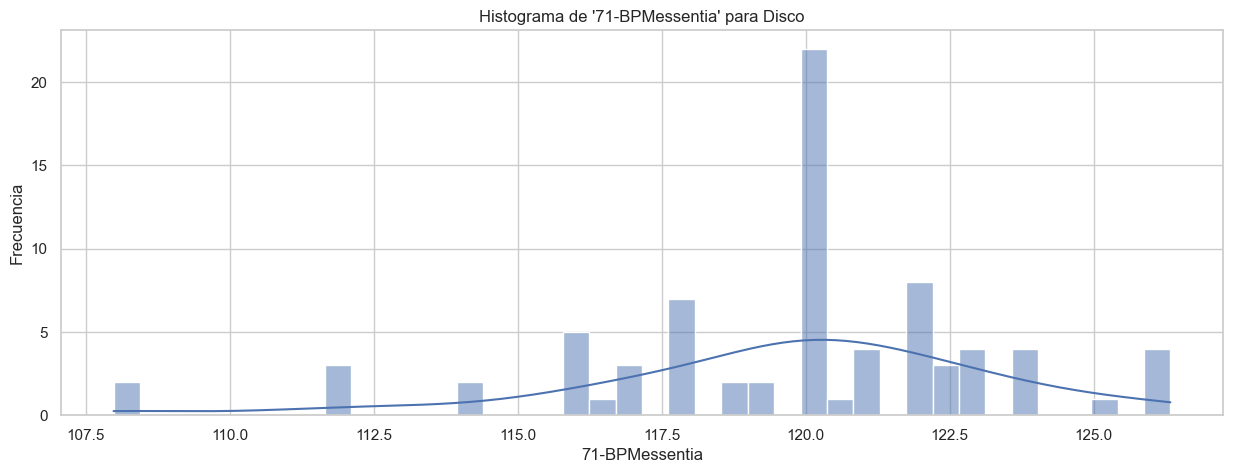

In [119]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Disco', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Disco")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

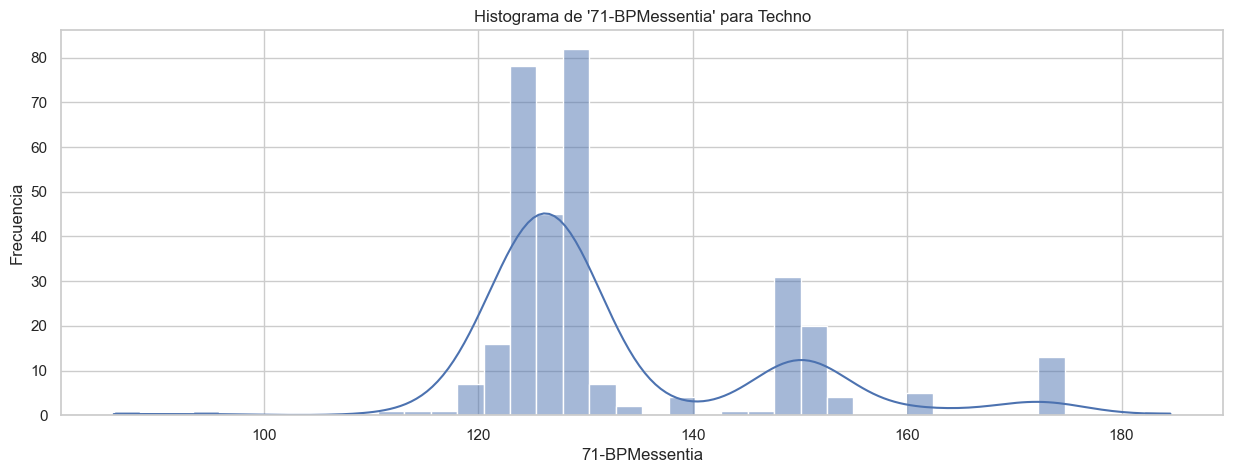

In [120]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Techno', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Techno")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

In [121]:
# Muestra los valores bajos de BPM en 'Techno', menor a 120
techno_low_bpm = train_set[(train_set['new_target'] == 'Techno') & (train_set['71-BPMessentia'] < 120)]
techno_low_bpm

1-ZCRm  2-Energym  3-EnergyEntropym  4-SpectralCentroidm  \
1242  0.166289   0.146447          3.212093             0.316669   
1284  0.103337   0.153590          3.163947             0.237816   
1604  0.067110   0.078719          3.181067             0.202819   
1644  0.130403   0.070037          3.025033             0.256260   
2104  0.047829   0.092854          3.082565             0.131942   
1265  0.088933   0.144556          3.091177             0.250610   
2110  0.053646   0.126420          3.108807             0.162015   
1679  0.027921   0.026805          2.955182             0.141050   
1634  0.065352   0.054317          3.132130             0.204808   
1698  0.048089   0.068803          3.049162             0.163093   

      5-SpectralSpreadm  6-SpectralEntropym  7-SpectralFluxm  \
1242           0.282388            1.329661         0.006800   
1284           0.245250            0.935755         0.004792   
1604           0.241222            0.566645         0.013012   
1644           0.248547            0.947103         0.017458   
2104           0.173013            0.486035         0.021653   
1265           0.267845            0.728885         0.010938   
2110           0.210046            0.440499         0.012409   
1679           0.209779            0.178951         0.021141   
1634           0.233670            0.414220         0.017745   
1698           0.219507            0.314798         0.018006   

      8-SpectralRolloffm  9-MFCCs1m  10-MFCCs2m  ...  \
1242            0.353608 -21.622198    1.418737  ...   
1284            0.157351 -21.204713    1.342749  ...   
1604            0.091552 -24.108749    1.881493  ...   
1644            0.229414 -24.269752    1.935716  ...   
2104            0.079202 -23.002968    1.680048  ...   
1265            0.137677 -22.554319    1.595829  ...   
2110            0.093052 -22.392807    2.397499  ...   
1679            0.043358 -27.574619    2.814826  ...   
1634            0.114851 -26.295248    3.019272  ...   
1698            0.066228 -24.752463    2.847763  ...   

      85-beats_loudness_band_ratio.mean5  86-beats_loudness_band_ratio.mean6  \
1242                            0.051377                            0.133243   
1284                            0.062986                            0.060310   
1604                            0.038069                            0.036943   
1644                            0.035018                            0.361901   
2104                            0.029918                            0.010850   
1265                            0.028735                            0.042415   
2110                            0.014019                            0.019032   
1679                            0.004011                            0.003110   
1634                            0.015901                            0.110777   
1698                            0.018178                            0.013157   

      87-beats_loudness_band_ratio.stdev1  \
1242                             0.269121   
1284                             0.259464   
1604                             0.421506   
1644                             0.379227   
2104                             0.217114   
1265                             0.214862   
2110                             0.206981   
1679                             0.063303   
1634                             0.450416   
1698                             0.331099   

      88-beats_loudness_band_ratio.stdev2  \
1242                             0.206505   
1284                             0.061084   
1604                             0.190771   
1644                             0.092074   
2104                             0.102749   
1265                             0.086011   
2110                             0.052210   
1679                             0.023990   
1634                             0.302319   
1698                             0.247378   

      89-beats_loudness_band_ratio.stdev3  \
1242               

Tambien los considero como Outliers para Techno, ya que los BPM para el género varían entre 120 y 140. 

In [122]:
# Elimina las filas con BPM bajo en 'Techno'
train_set = train_set.drop(techno_low_bpm.index)


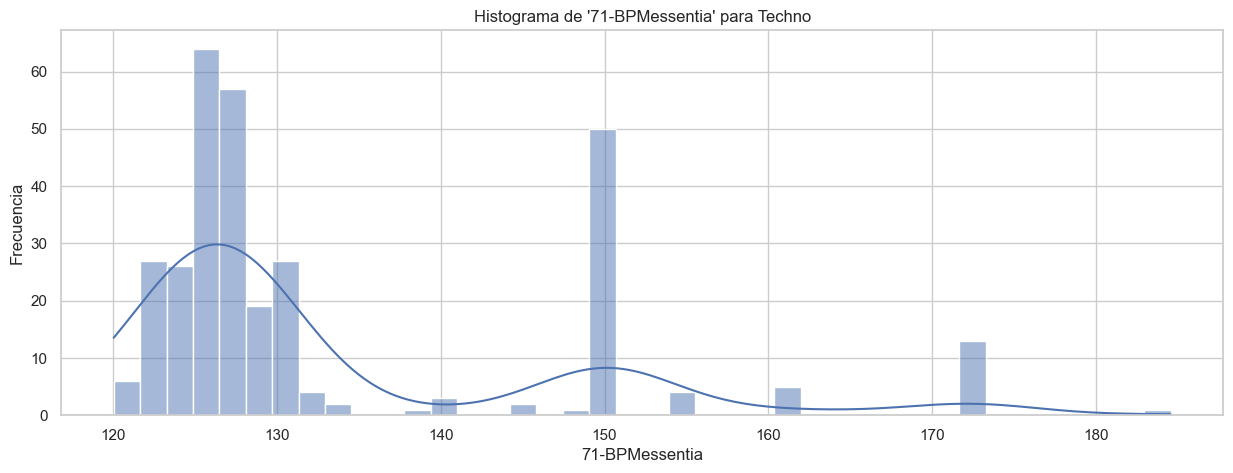

In [123]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Techno', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Techno")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

In [124]:
#Analizo los valores de BPM por genero nuevamente
train_set.groupby('new_target')['71-BPMessentia'].describe()

count        mean        std         min         25%         50%  \
new_target                                                                     
Disco        78.0  119.685580   3.639058  107.985764  117.981243  120.023430   
Downtempo    84.0   72.069672  17.624532   55.019028   60.010982   62.504862   
Garage       83.0  142.836604  16.795116   69.972511  140.022057  144.903656   
House       634.0  123.941752   6.757330   63.974220  122.078251  123.971916   
Techno      312.0  133.531976  13.378381  120.023705  124.991304  127.994862   
Trance      164.0  137.686653   8.644252   79.623276  136.474342  137.926003   
Urban       474.0  118.299761  23.197384   72.108147  100.019081  115.997669   

                   75%         max  
new_target                          
Disco       122.055992  126.333145  
Downtempo    88.366415  107.024689  
Garage      150.184715  172.265747  
House       126.136183  161.694656  
Techno      139.761929  184.570297  
Trance      139.938461  184.570206  
Urban       131.580307  178.205811

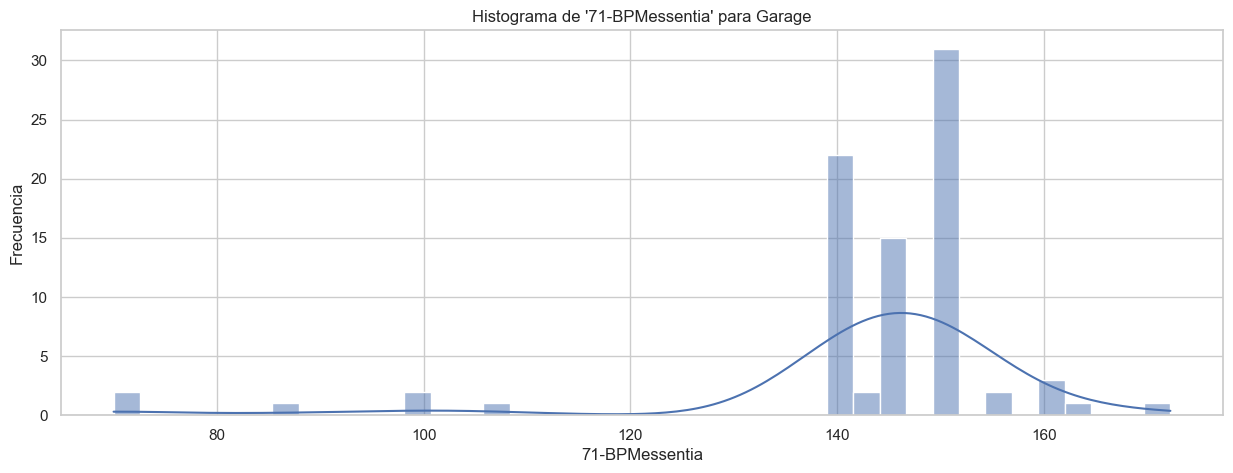

In [125]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Garage', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Garage")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

Todo lo que este por debajo de 140, lo elimino, considerandolo un Outlier tambien.

In [126]:
garage_low_bpm = train_set[(train_set['new_target'] == 'Garage') & (train_set['71-BPMessentia'] < 120)]
garage_low_bpm

1-ZCRm  2-Energym  3-EnergyEntropym  4-SpectralCentroidm  \
575  0.136798   0.155504          3.191995             0.299282   
551  0.081654   0.158408          3.127390             0.250791   
592  0.167773   0.087253          3.168209             0.284929   
566  0.064431   0.237605          3.148885             0.202214   
569  0.055188   0.147521          2.925529             0.180561   
562  0.130976   0.067462          3.110278             0.276014   

     5-SpectralSpreadm  6-SpectralEntropym  7-SpectralFluxm  \
575           0.268769            1.219898         0.005840   
551           0.263645            0.645496         0.009624   
592           0.230421            1.408471         0.006476   
566           0.228506            0.651056         0.010741   
569           0.241277            0.351434         0.011888   
562           0.254315            1.178837         0.008697   

     8-SpectralRolloffm  9-MFCCs1m  10-MFCCs2m  ...  \
575            0.272780 -21.670641    1.103134  ...   
551            0.133525 -23.489962    1.631974  ...   
592            0.325909 -23.291910    0.655826  ...   
566            0.101779 -22.112489    1.416971  ...   
569            0.063677 -24.765009    2.241099  ...   
562            0.242165 -23.623098    1.041178  ...   

     85-beats_loudness_band_ratio.mean5  86-beats_loudness_band_ratio.mean6  \
575                            0.079361                            0.223291   
551                            0.052312                            0.216097   
592                            0.100017                            0.158510   
566                            0.031429                            0.054364   
569                            0.073314                            0.054759   
562                            0.082467                            0.102208   

     87-beats_loudness_band_ratio.stdev1  88-beats_loudness_band_ratio.stdev2  \
575                             0.361784                             0.083519   
551                             0.351546                             0.075741   
592                             0.309293                             0.105436   
566                             0.336781                             0.299626   
569                             0.281471                             0.108178   
562                             0.381937                             0.202904   

     89-beats_loudness_band_ratio.stdev3  90-beats_loudness_band_ratio.stdev4  \
575                             0.166867                             0.094983   
551                             0.056121                             0.062024   
592                             0.228480                             0.161998   
566                             0.055921                             0.083253   
569                             0.033745                             0.050157   
562                             0.121561                             0.158798   

     91-beats_loudness_band_ratio.stdev5  92-beats_loudness_band_ratio.stdev6  \
575                             0.069510                             0.238752   
551                             0.065567                             0.240262   
592                             0.101873                             0.172386   
566                             0.032940                             0.048786   
569                             0.138942                             0.108206   
562                             0.096806                             0.106343   

       class  new_target  
575  Dubstep      Garage  
551  Dubstep      Garage  
592  Dubstep      Garage  
566  Dubstep      Garage  
569  Dubstep      Garage  
562  Dubstep      Garage  

[6 rows x 94 columns]

También fue un género recategorizado, pero el dubstep sus BPM van de 130 a 150 y Garage rondan los 130, entonces considero estos valores como extraños y los elimino

In [127]:
train_set = train_set.drop(garage_low_bpm.index)

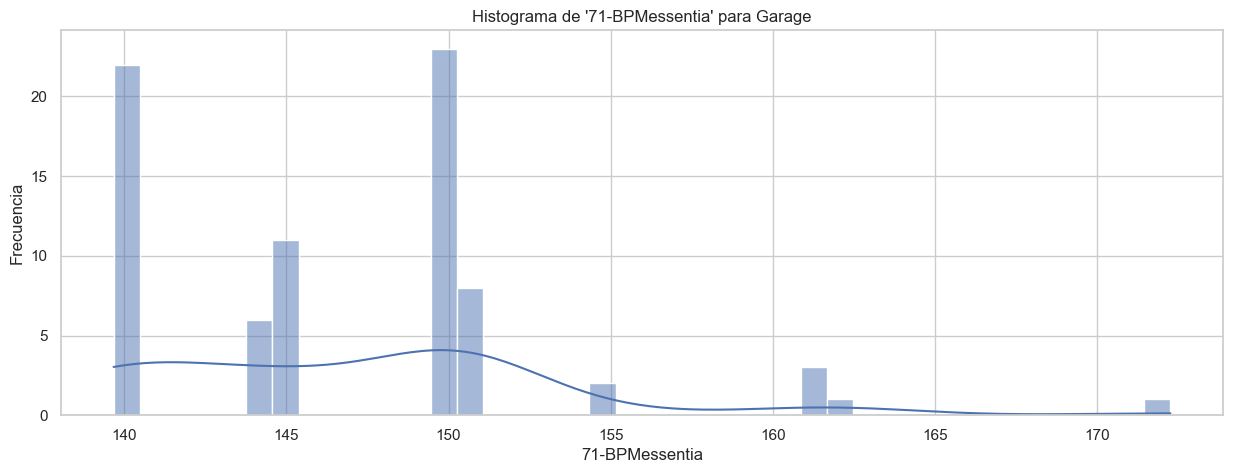

In [128]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Garage', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Garage")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

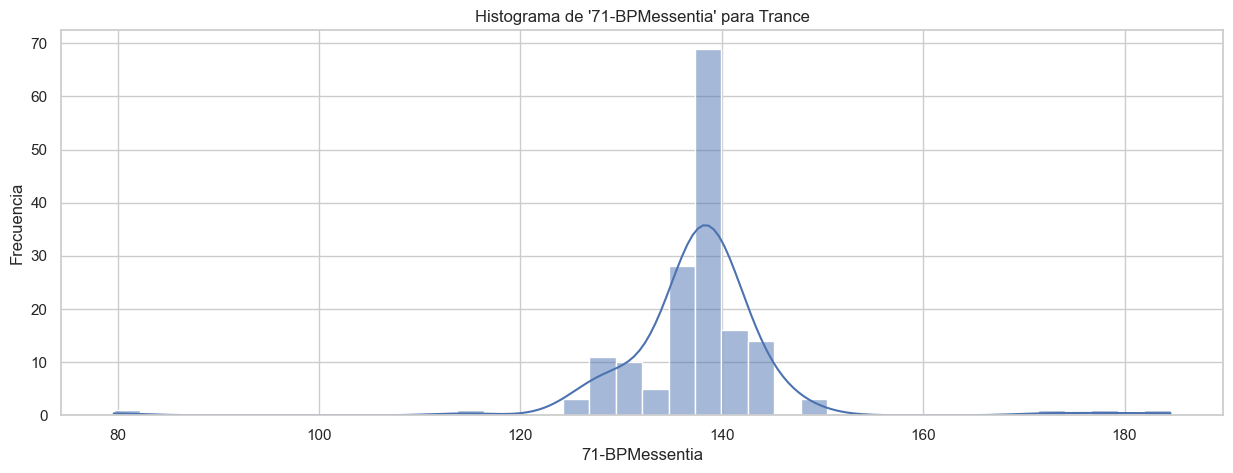

In [129]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Trance', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Trance")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

In [130]:
trance_low_bpm = train_set[(train_set['new_target'] == 'Trance') & (train_set['71-BPMessentia'] < 120)]
trance_low_bpm

1-ZCRm  2-Energym  3-EnergyEntropym  4-SpectralCentroidm  \
1869  0.173972   0.036442          3.198635             0.295082   
2261  0.144853   0.110786          3.223498             0.292698   

      5-SpectralSpreadm  6-SpectralEntropym  7-SpectralFluxm  \
1869           0.252508            1.571336         0.003405   
2261           0.256129            1.398321         0.003937   

      8-SpectralRolloffm  9-MFCCs1m  10-MFCCs2m  ...  \
1869            0.380755 -23.268480    1.079315  ...   
2261            0.295019 -21.694595    0.618753  ...   

      85-beats_loudness_band_ratio.mean5  86-beats_loudness_band_ratio.mean6  \
1869                            0.099816                            0.179812   
2261                            0.117488                            0.086111   

      87-beats_loudness_band_ratio.stdev1  \
1869                             0.265156   
2261                             0.270669   

      88-beats_loudness_band_ratio.stdev2  \
1869                             0.088065   
2261                             0.151244   

      89-beats_loudness_band_ratio.stdev3  \
1869                             0.078801   
2261                             0.085904   

      90-beats_loudness_band_ratio.stdev4  \
1869                             0.085175   
2261                             0.109433   

      91-beats_loudness_band_ratio.stdev5  \
1869                             0.071863   
2261                             0.125131   

      92-beats_loudness_band_ratio.stdev6      class  new_target  
1869                             0.170421  PsyTrance      Trance  
2261                             0.072674     Trance      Trance  

[2 rows x 94 columns]

Estos Outliers por debajo de 120 los eliminamos tambien

In [131]:
train_set = train_set.drop(trance_low_bpm.index)

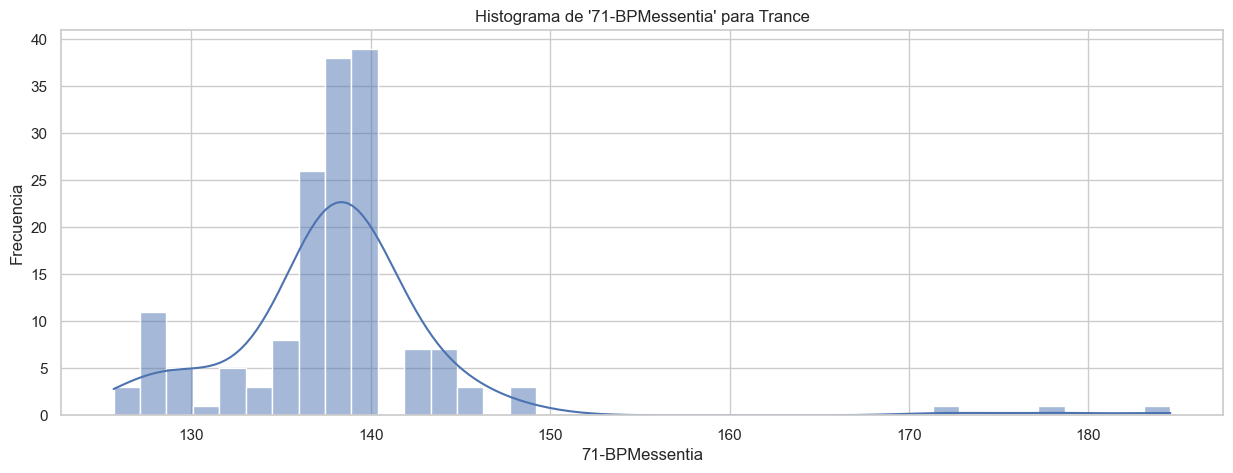

In [132]:
plt.figure(figsize=(15, 5))
sns.histplot(train_set.loc[train_set['new_target'] == 'Trance', '71-BPMessentia'], bins=40, kde=True)
plt.title("Histograma de '71-BPMessentia' para Trance")
plt.xlabel('71-BPMessentia')
plt.ylabel('Frecuencia')
plt.show()

In [133]:
trance_high_bpm = train_set[(train_set['new_target'] == 'Trance') & (train_set['71-BPMessentia'] > 150)]
trance_high_bpm

1-ZCRm  2-Energym  3-EnergyEntropym  4-SpectralCentroidm  \
2280  0.162441   0.077490          3.145005             0.283855   
2251  0.104100   0.101286          3.132801             0.221238   
2272  0.120556   0.059789          3.150238             0.247072   

      5-SpectralSpreadm  6-SpectralEntropym  7-SpectralFluxm  \
2280           0.255027            1.393799         0.008402   
2251           0.225690            0.965736         0.006810   
2272           0.247381            1.072329         0.007319   

      8-SpectralRolloffm  9-MFCCs1m  10-MFCCs2m  ...  \
2280            0.331257 -23.777720    0.955389  ...   
2251            0.192341 -22.116412    1.730508  ...   
2272            0.215067 -22.686297    1.613355  ...   

      85-beats_loudness_band_ratio.mean5  86-beats_loudness_band_ratio.mean6  \
2280                            0.106348                            0.128322   
2251                            0.078851                            0.071082   
2272                            0.062514                            0.057643   

      87-beats_loudness_band_ratio.stdev1  \
2280                             0.326674   
2251                             0.249153   
2272                             0.231608   

      88-beats_loudness_band_ratio.stdev2  \
2280                             0.075064   
2251                             0.155012   
2272                             0.251229   

      89-beats_loudness_band_ratio.stdev3  \
2280                             0.142037   
2251                             0.099434   
2272                             0.130405   

      90-beats_loudness_band_ratio.stdev4  \
2280                             0.165790   
2251                             0.074175   
2272                             0.084527   

      91-beats_loudness_band_ratio.stdev5  \
2280                             0.100946   
2251                             0.063328   
2272                             0.056750   

      92-beats_loudness_band_ratio.stdev6   class  new_target  
2280                             0.112135  Trance      Trance  
2251                             0.066435  Trance      Trance  
2272                             0.058180  Trance      Trance  

[3 rows x 94 columns]

Los valores altos también me llaman la atención, pero están dentro de lo esperado para el género, los mantengo. Observo como quedo la distribución del target

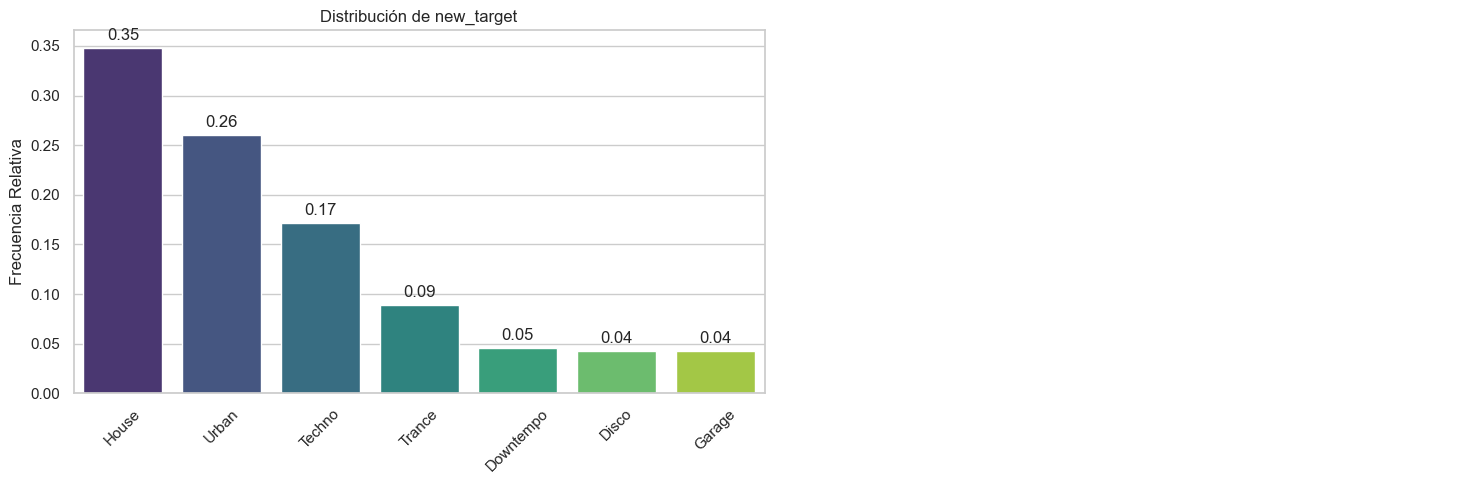

In [134]:
bt.pinta_distribucion_categoricas(train_set, columnas_categoricas=[target], mostrar_valores=True, relativa=True)

Perfecto.

Paso ahora a visualizar las funciones de densidad por género para las variables seleccionadas por mi test de ANOVA, ya con los datos limpios. Escogí esta visualización ya que al tener múltiples categorías objetivo, creo que se puede apreciar mejor. 

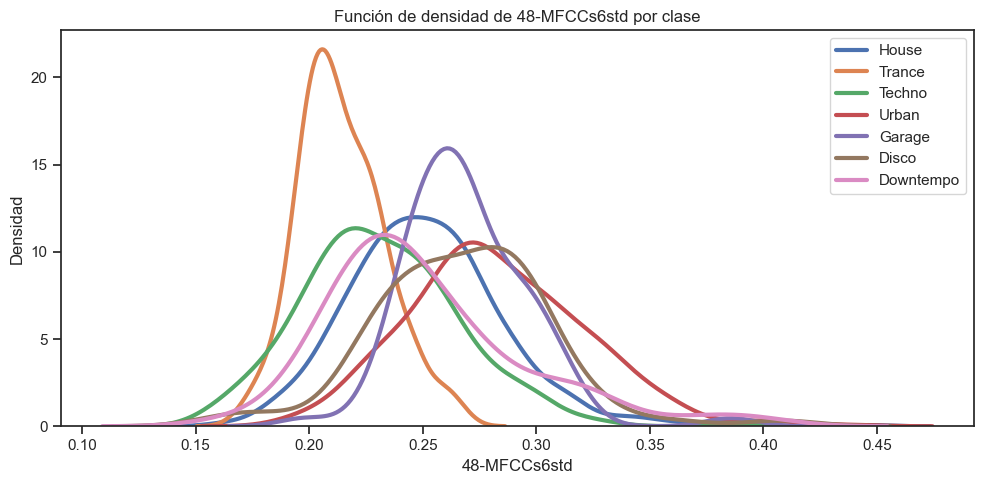

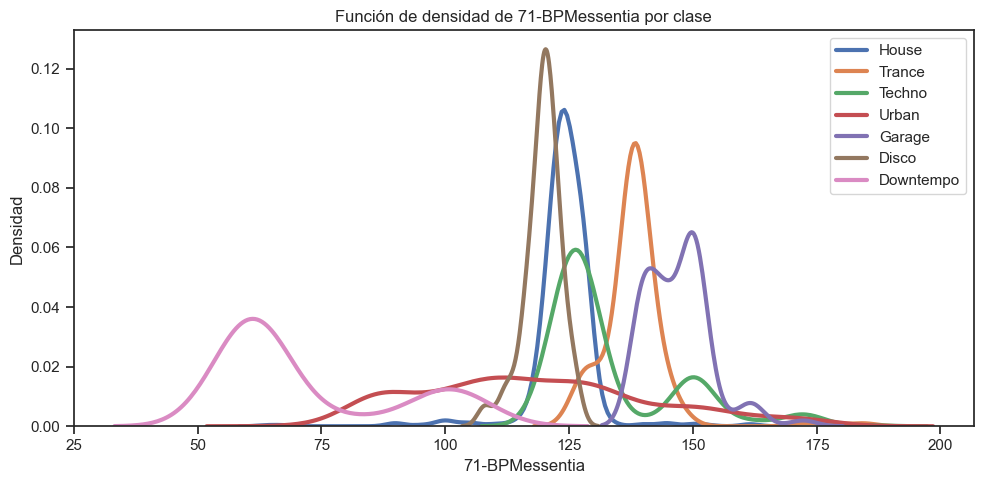

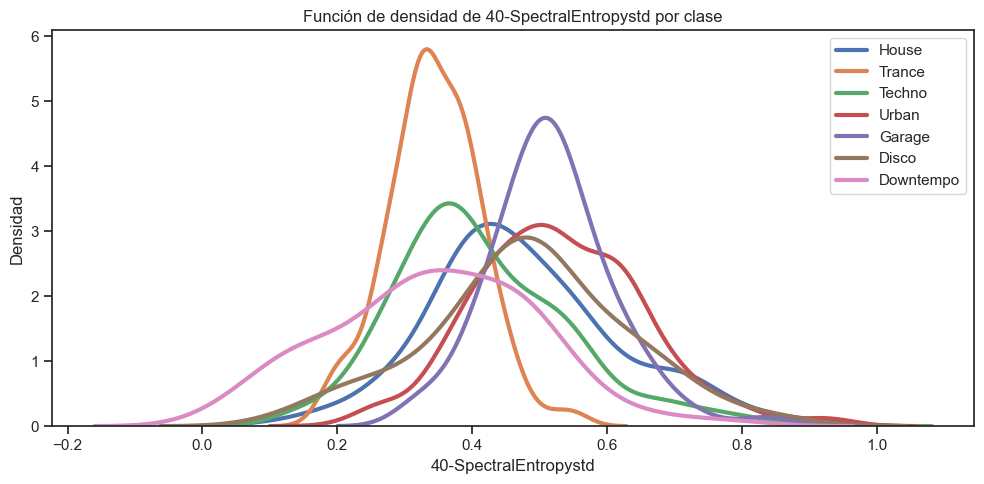

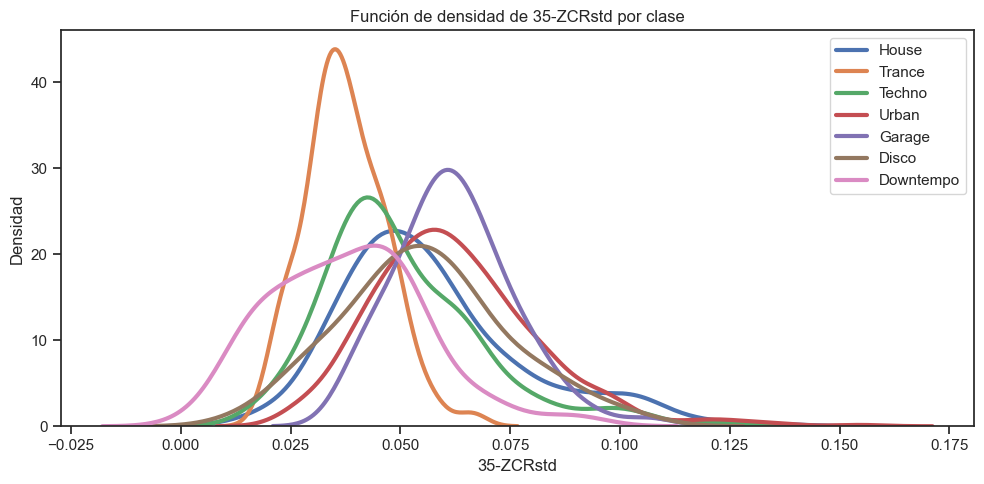

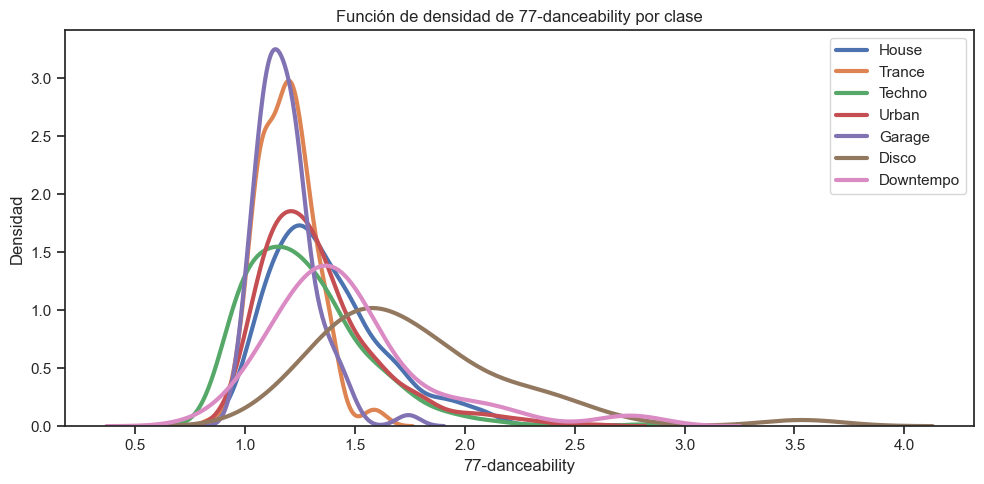

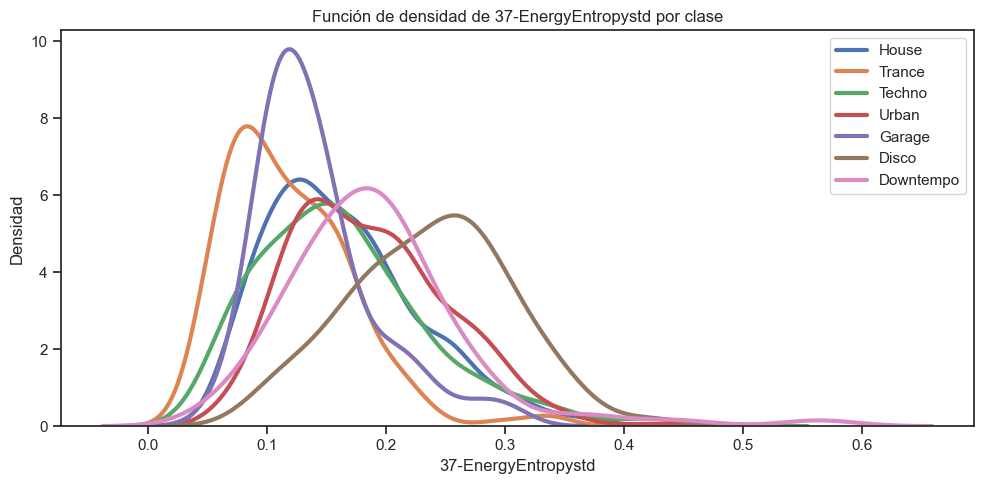

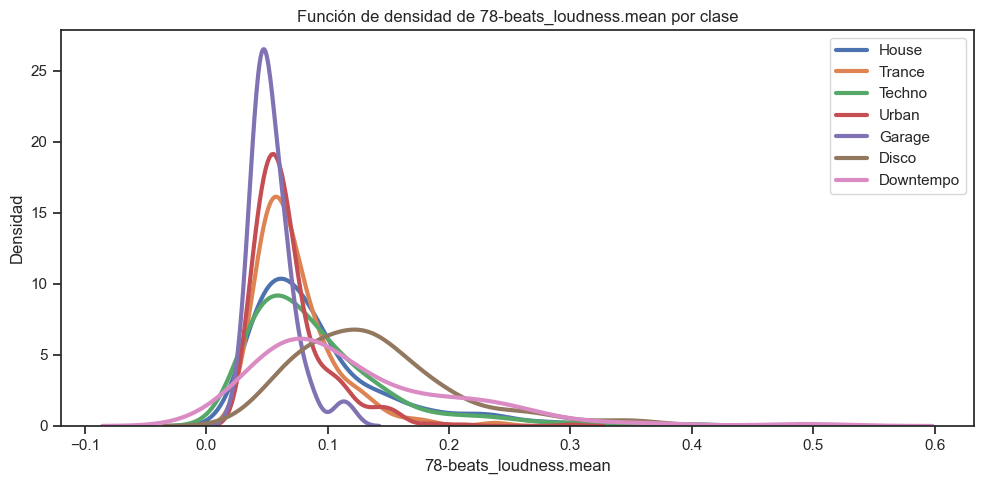

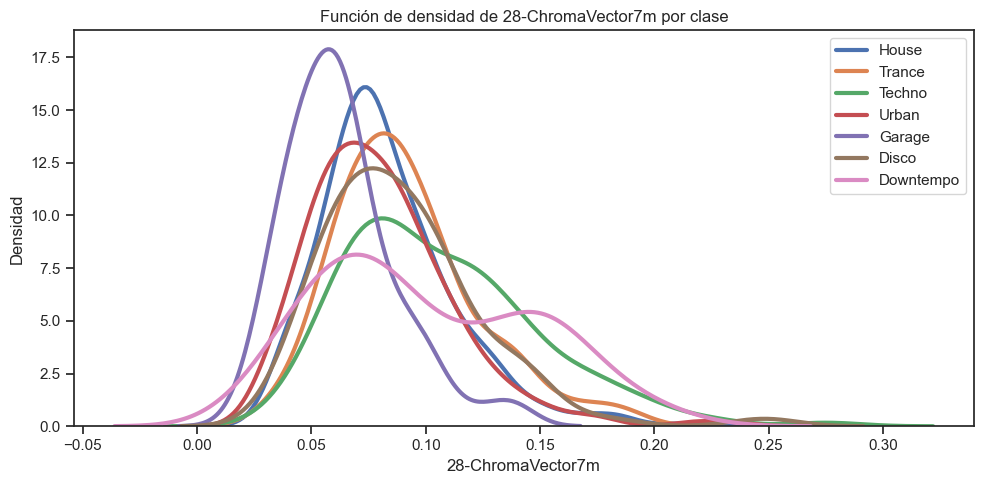

In [135]:
sns.set(style="ticks")
for feature in selected_features:
    plt.figure(figsize=(10, 5))
    for clase in train_set['new_target'].unique():
        sns.kdeplot(
            data=train_set[train_set['new_target'] == clase],
            x=feature,
            label=clase,
            linewidth=3
        )
    plt.title(f"Función de densidad de {feature} por clase")
    plt.xlabel(feature)
    plt.ylabel("Densidad")
    plt.legend()
    plt.tight_layout()
    plt.show()

- La varianza de los coeficientes MFCC6 sugiere diferencias significativas en la complejidad armónica entre géneros. El Trance se distingue claramente por su menor dispersión y pico más alto, Urban y Garage muestran valores mayores.

- 71-BPMessentia como ya sabíamos de ante mano, discrimina perfecto por género, ya que el tempo es una de las características determinantes al momento de definir ciertos géneros. 

- Variables como 71-BPMessentia, 40-SpectralEntropystd, 35-ZCRstd, 37-EnergyEntropystd, y 48-MFCCs6std muestran distribuciones bien diferenciadas por clase y por tanto alta capacidad discriminativa.

- 77-danceability y 78-beats_loudness.mean también aportan valor, aunque con algo más de solapamiento.

- 28-ChromaVector7m es relevante, pero quizás algo menos diferenciadora que el resto.

- Me doy cuenta que las graficas de 35-ZCRstd y 37-EnergyEntropystd tienen una distribución casi idéntica. Se tendrá en cuenta al momento de analizar la correlación.

In [136]:
train_set[selected_features].describe().T

count        mean        std        min         25%  \
48-MFCCs6std            1821.0    0.253998   0.040928   0.153214    0.224669   
71-BPMessentia          1821.0  123.784726  19.921969  55.019028  120.018951   
40-SpectralEntropystd   1821.0    0.464001   0.144250   0.026146    0.366833   
35-ZCRstd               1821.0    0.054792   0.020358   0.003630    0.040734   
77-danceability         1821.0    1.342910   0.295779   0.830938    1.141607   
37-EnergyEntropystd     1821.0    0.168964   0.069960   0.040537    0.117147   
78-beats_loudness.mean  1821.0    0.086387   0.055580   0.018995    0.051248   
28-ChromaVector7m       1821.0    0.087540   0.035639   0.021836    0.063299   

                               50%         75%         max  
48-MFCCs6std              0.251235    0.277686    0.445822  
71-BPMessentia          124.998711  129.991867  184.570297  
40-SpectralEntropystd     0.454059    0.551830    0.954895  
35-ZCRstd                 0.051716    0.065678    0.154560  
77-danceability           1.274791    1.470253    3.552394  
37-EnergyEntropystd       0.158337    0.210780    0.563781  
78-beats_loudness.mean    0.068922    0.101925    0.493668  
28-ChromaVector7m         0.080594    0.104891    0.281762

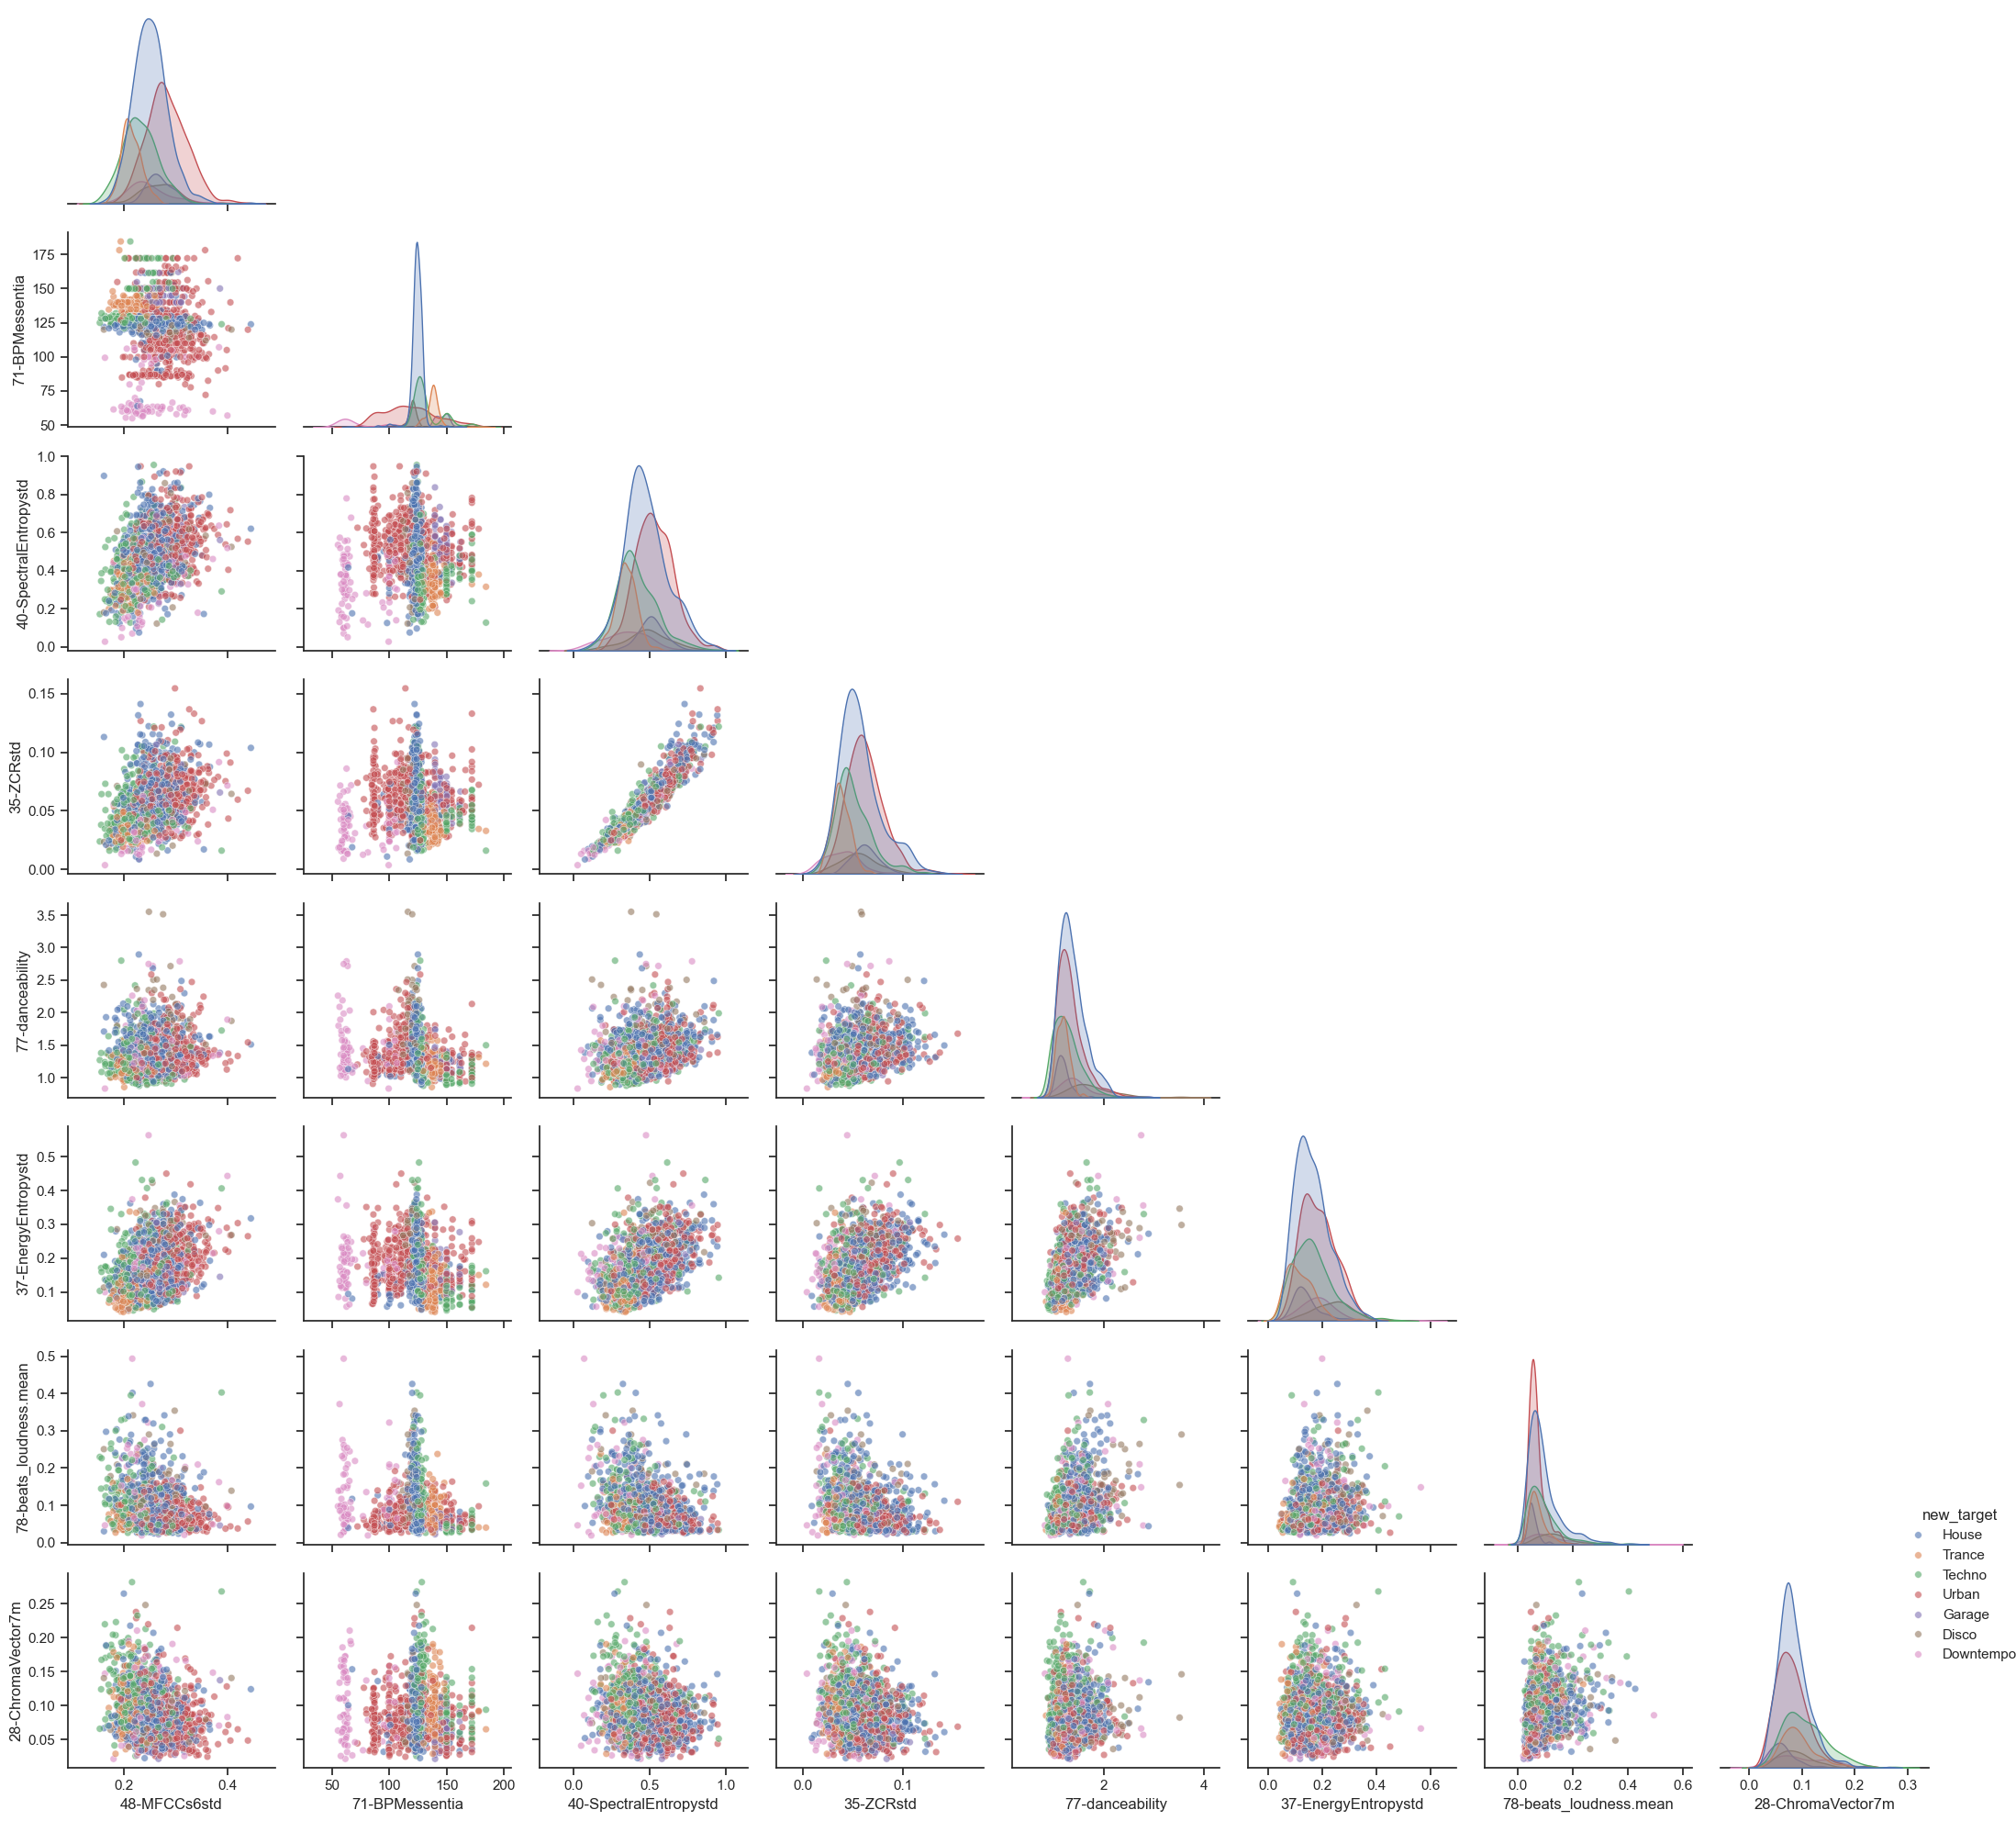

In [137]:
new_target = 'new_target'

sns.set(style="ticks")
pairplot_fig = sns.pairplot(
    train_set[selected_features + [new_target]],
    hue=new_target,
    plot_kws={"alpha": 0.6, "s": 30},
    corner=True
)
plt.tight_layout()

pairplot_fig._legend.set_bbox_to_anchor((1, 0.08))
pairplot_fig._legend.set_loc("lower center")
plt.show()

- Podemos observar en la columna de '71-BPMessentia' como se forman filas verticales para géneros como House, Urban, Techno, Trance y Downtempo son los que mejor discriminados se ven. Luego no se observa una separación fuerte entre géneros en las otras variables, salvo entre 35-ZCRstd y 40-SpectralEntropystd que parecería haber algún tipo de forma/figura a agrupar tambien. 
- 35-ZCRstd y 40-SpectralEntropystd tienen una relación positiva fuerte. Esto sugiere que estas tres variables están capturando una dimensión común del espectro energético/frecuencial.
- 77-danceability y 71-BPMessentia no tienen correlación aparente con otras variables, esto es bueno ya que aportan nueva información no redundante. 
- No se observa una separación visual fuerte entre géneros, pero algunas combinaciones como 'BPMessentia' vs 'MFCCs6std' muestran agrupamientos parciales. Me doy cuenta que géneros como House, Urban, Techno y Trance (que también son los que mayor frecuencia tienen) son los que mejor discriminados se ven por '71-BPMessentia' y ''48-MFCCs6std'

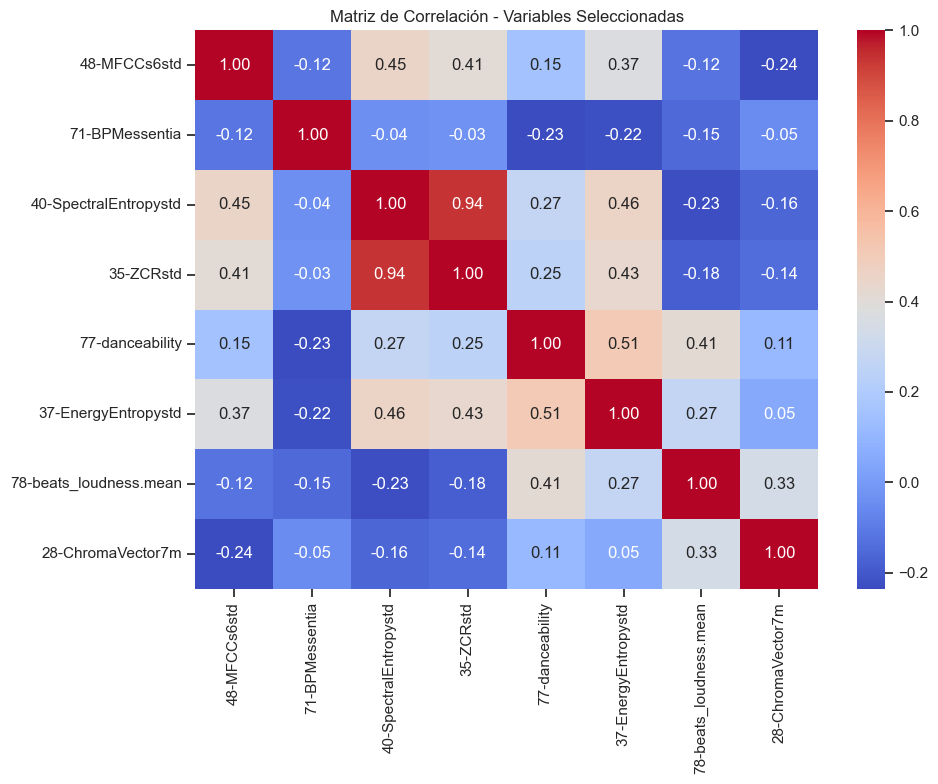

In [138]:

# Matriz de correlación de las features seleccionadas
correlation_matrix = train_set[selected_features].corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación - Variables Seleccionadas")
plt.tight_layout()
plt.show()

'40-SpectralEntropystd': La entropía espectral es una medida de la complejidad o desorden en un espectro de frecuencias,
'1- ZCRstd': es la métrica utilizada en el procesamiento de señales que indica la velocidad a la que una señal cambia de signo, es decir, de positiva a negativa o viceversa.
Por su alta colinealidad y lo que ambas significan, me decido por mantener '1- ZCRmstd'

In [139]:
selected_features.remove('40-SpectralEntropystd')

In [140]:
train_set[selected_features].describe().T

count        mean        std        min         25%  \
48-MFCCs6std            1821.0    0.253998   0.040928   0.153214    0.224669   
71-BPMessentia          1821.0  123.784726  19.921969  55.019028  120.018951   
35-ZCRstd               1821.0    0.054792   0.020358   0.003630    0.040734   
77-danceability         1821.0    1.342910   0.295779   0.830938    1.141607   
37-EnergyEntropystd     1821.0    0.168964   0.069960   0.040537    0.117147   
78-beats_loudness.mean  1821.0    0.086387   0.055580   0.018995    0.051248   
28-ChromaVector7m       1821.0    0.087540   0.035639   0.021836    0.063299   

                               50%         75%         max  
48-MFCCs6std              0.251235    0.277686    0.445822  
71-BPMessentia          124.998711  129.991867  184.570297  
35-ZCRstd                 0.051716    0.065678    0.154560  
77-danceability           1.274791    1.470253    3.552394  
37-EnergyEntropystd       0.158337    0.210780    0.563781  
78-beats_loudness.mean    0.068922    0.101925    0.493668  
28-ChromaVector7m         0.080594    0.104891    0.281762

Observo que los datos se encuentran estandarizados al parecer, no veo ninguna distribución extraña, teniendo en cuenta que son resultados de un análisis de una onda de audio. Por conocimiento de negocio está bien que haya una mayor amplitud y discreción de valores en '71-BPMessentia' ya que se refiere al tempo de la muestra de audio y esta puede ir de 0 a 240 practicamente. 

#### Respuestas

<p align="center" style="font-size:2em; font-family:'Segoe UI', 'Arial', sans-serif;">
1.¿Qué género es el más bailable?
</p>

![danceability_barplot.png](./src/img/danceability_barplot.png?cache={cache_buster})

<p style="font-size:1.25em;">
No exactamente.<br>
Aunque el House es conocido por su ritmo envolvente, el análisis revela que <b>Disco</b> lidera en promedio de <i>danceability</i>, seguido por <b>Downtempo</b> y recién en tercer lugar aparece <b>House</b>. Esto sugiere que, en términos acústicos, Disco es el género más propicio para bailar, al menos según esta métrica.<br>
El resultado puede sorprender, pero refleja cómo ciertos géneros clásicos siguen destacándose por su estructura rítmica diseñada para la pista de baile.
</p>

<p align="center" style="font-size:2em; font-family:'Segoe UI', 'Arial', sans-serif;">
2.¿Qué género presenta mayor energía o intensidad percibida?
</p>

![energia_por_genero1.png](./src/img/energia_por_genero1.png?cache={cache_buster})

<p style="font-size:1.25em;">
El análisis revela que el género <b>Garage</b> encabeza la lista en términos de <i>energía percibida</i>, seguido por <b>Techno</b> y <b>Urban</b>. Esto sugiere que estos géneros tienden a tener características acústicas más intensas o dinámicas, ideales para mantener una atmósfera activa y estimulante.<br>
Por el contrario, géneros como <b>Downtempo</b> y <b>Disco</b> se encuentran en los últimos lugares del ranking, lo cual es coherente con su naturaleza más relajada y melódica. En resumen, no toda la música electrónica es igual de enérgica, y existen matices significativos según el estilo.
</p>

<p align="center" style="font-size:2em; font-family:'Segoe UI', 'Arial', sans-serif;">
3."La música electrónica es puro ruido" (?)
</p>

![Tempo1.png](./src/img/Tempo1.png?cache={cache_buster})

![ZCR1.png](./src/img/ZCR1.png?cache={cache_buster})

![Energy.png](./src/img/Energy.png?cache={cache_buster})

<p style="font-size:1.25em;">
<b>No.</b><br>
A través de indicadores técnicos como <b>ZCR (punto de cruce a cero)</b>, <b>energía</b> y <b>tempo</b>, vemos que algunos géneros electrónicos tienen estructuras más limpias o suaves que varios géneros tradicionales.
Géneros como <b>metal, pop o hiphop</b> presentan valores iguales o incluso más altos que estilos electrónicos como <b>house o trance.</b>
Estos últimos tienen niveles de intensidad similares o mayores que varios subgéneros electrónicos.<br>
La electrónica puede ser más repetitiva o sintética, pero no necesariamente más ruidosa o caótica.<br>
La energía y complejidad <b>no son exclusivas de la música electrónica.</b><br>
Fuente: <a href="https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/data">GTZAN Dataset - Music Genre Classification</a>
</p>

<p align="center" style="font-size:2em; font-family:'Segoe UI', 'Arial', sans-serif;">
4. ¿Cómo diferenciamos los géneros?
</p>

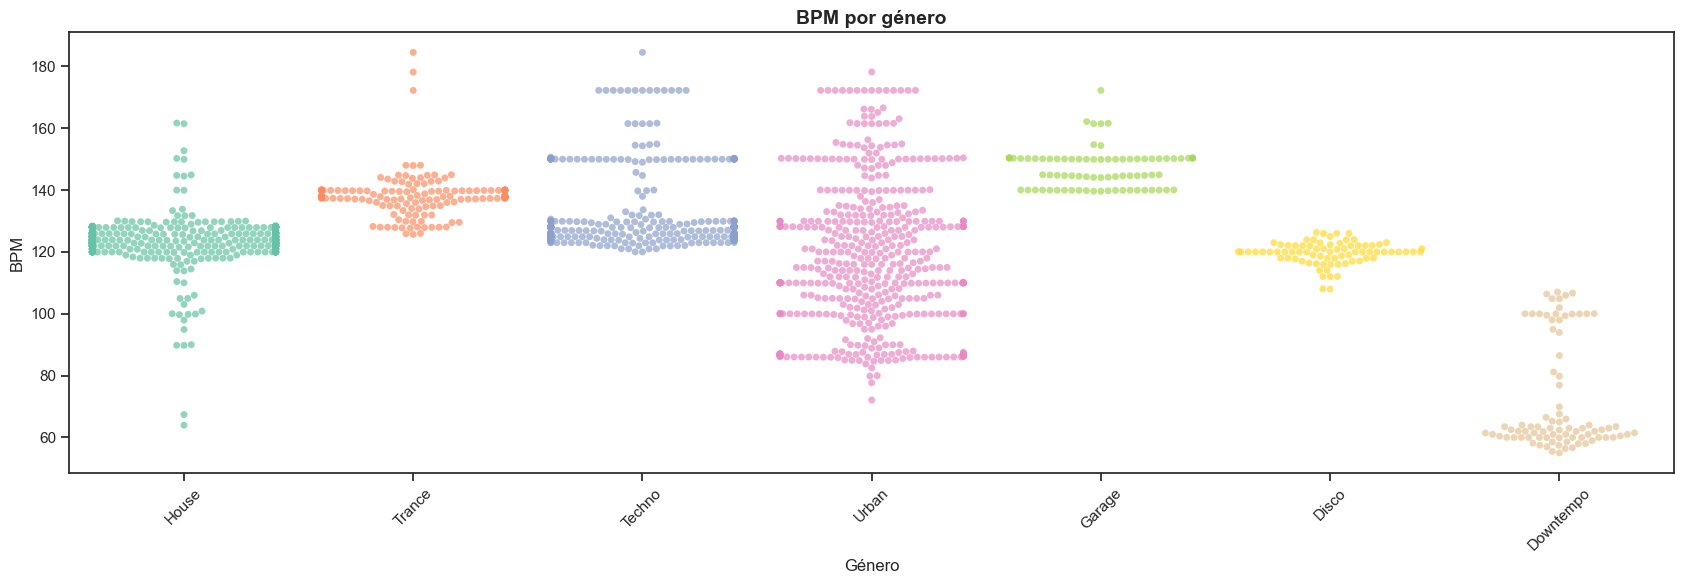

In [141]:
import warnings

warnings.filterwarnings('ignore')

plt.figure(figsize=(17, 6))
sns.swarmplot(data=train_set, x='new_target', y='71-BPMessentia', palette='Set2', alpha=0.7, size=5)
plt.title("BPM por género", fontsize=14, fontweight='bold')
plt.xlabel("Género")
plt.ylabel("BPM")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('./src/img/BPM_por_genero_swarmplot.jpg')
plt.show()

<p style="font-size:1.25em;">
El <b>BPM</b> es una variable útil, pero no suficiente por sí sola para separar todos los géneros. Es ideal combinarla con otras características (como ZCR y Energia) para mejorar la diferenciación.
</p>


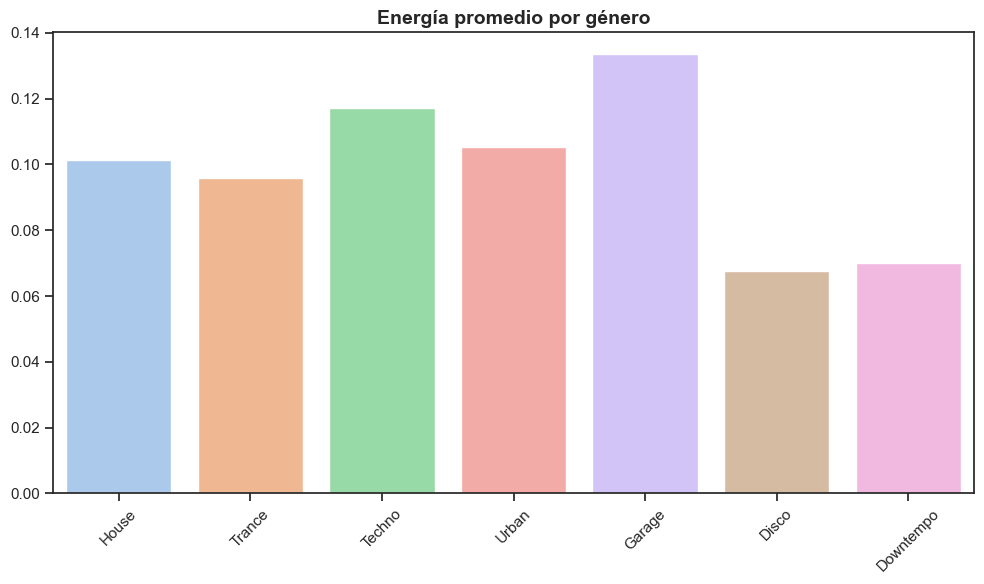

In [142]:
plt.figure(figsize=(10, 6))
sns.barplot(data=train_set, x='new_target', y='2-Energym', errorbar=None, palette='pastel')
plt.title("Energía promedio por género", fontsize=14, fontweight='bold')
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('./src/img/energia_promedio_por_genero.jpg')
plt.show()

<p style="font-family: 'Segoe UI', 'Arial', sans-serif; font-size: 1.15em;">
El análisis de la energía promedio revela diferencias significativas entre los géneros de música electrónica en cuanto a intensidad percibida.<br><br>
<b>Garage</b> destaca como el género con mayor energía promedio, lo que refleja su carácter enérgico y denso.<br><br>
<b>Techno</b> y <b>Urban</b> también presentan niveles altos de energía, indicando una textura sonora más potente y continua.<br><br>
<b>Disco</b> y <b>Downtempo</b>, en cambio, muestran las energías más bajas, lo que coincide con sus estilos más relajados, nostálgicos o ambientales.<br><br>
<b>House</b> y <b>Trance</b> se ubican en niveles intermedios, lo que los posiciona como géneros balanceados en términos de intensidad.<br>

Esta métrica puede ayudar a clasificar géneros no solo por ritmo, sino también por su impacto acústico, permitiendo distinguir entre estilos diseñados para la pista de baile y otros más contemplativos o chill.

</p>


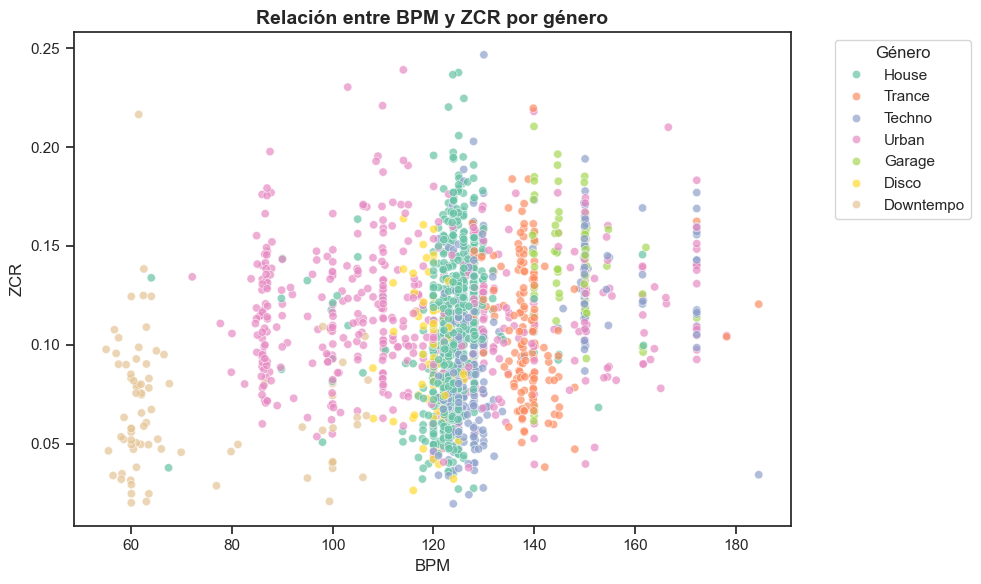

In [143]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=train_set,
    x='71-BPMessentia',
    y='1-ZCRm',
    hue='new_target',
    palette='Set2',
    alpha=0.7
)
plt.title("Relación entre BPM y ZCR por género", fontsize=14, fontweight='bold')
plt.xlabel("BPM")
plt.ylabel("ZCR")
plt.legend(title="Género", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('./src/img/ZCR_BPM_por_genero_scatteplot.jpg')
plt.show()

<p style="font-family: 'Segoe UI', 'Arial', sans-serif; font-size: 1.15em;">
<b>Downtempo</b> se distingue fácilmente: baja velocidad (<b>BPM</b> &lt; 80) y baja complejidad (<b>ZCR</b> &lt; 0.1), ideal para atmósferas relajadas.<br><br>
<b>Techno</b>, <b>Garage</b> y <b>Trance</b> comparten <b>BPM</b> altos, pero difieren en su <b>ZCR</b>: por ejemplo, <b>Techno</b> mantiene una baja complejidad mientras <b>Garage</b> tiende a ser más denso sonoramente.<br><br>
<b>Urban</b> destaca por su amplia dispersión en <b>ZCR</b>, indicando una gran variedad interna en términos de textura y ritmo.<br><br>
<b>House</b> se mantiene estable cerca de los 125 <b>BPM</b>, con una <b>ZCR</b> moderada, reflejando su carácter rítmico y repetitivo.<br><br>
Si tuviéramos que clasificar géneros solo con dos variables, <b>BPM</b> y <b>ZCR</b> serían una dupla poderosa. Este gráfico demuestra que muchos géneros ocupan zonas acústicas particulares, lo que abre la puerta a modelos de clasificación y a una comprensión más rica de la música electrónica.
</p>

# 6. Feat. Red. Preliminar

In [144]:
#Me guardo mi primera seleccion de features

features_eda = selected_features
features_eda

['48-MFCCs6std',
 '71-BPMessentia',
 '35-ZCRstd',
 '77-danceability',
 '37-EnergyEntropystd',
 '78-beats_loudness.mean',
 '28-ChromaVector7m']

In [145]:
#Separo
X_train = train_set.drop(['class','new_target','69-BPM', '70-BPMconf'], axis=1)
y_train = train_set['new_target']

X_test = test_set.drop(['class','new_target','69-BPM', '70-BPMconf'], axis=1)
y_test = test_set['new_target']

In [146]:
# Codificar etiquetas
le = LabelEncoder()
y_train_e = le.fit_transform(y_train)
y_test_e = le.fit_transform(y_test)

In [147]:
print(X_train.shape)
print(y_train_e.shape)
print(y_test_e.shape)
print(X_test.shape)

(1821, 90)
(1821,)
(460,)
(460, 90)


In [148]:
# Entreno un Random Forest para obtener importancias
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_e)


importances = rf.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)


In [149]:
features_importance = feature_importance_df['Feature'].head(30).tolist()
features_importance

['71-BPMessentia',
 '72-bpm_histogram_first_peak_bpm',
 '48-MFCCs6std',
 '74-bpm_histogram_second_peak_bpm',
 '52-MFCCs10std',
 '54-MFCCs12std',
 '49-MFCCs7std',
 '7-SpectralFluxm',
 '50-MFCCs8std',
 '55-MFCCs13std',
 '44-MFCCs2std',
 '47-MFCCs5std',
 '38-SpectralCentroidstd',
 '53-MFCCs11std',
 '79-beats_loudness.stdev',
 '51-MFCCs9std',
 '2-Energym',
 '3-EnergyEntropym',
 '77-danceability',
 '40-SpectralEntropystd',
 '41-SpectralFluxstd',
 '45-MFCCs3std',
 '10-MFCCs2m',
 '39-SpectralSpreadstd',
 '35-ZCRstd',
 '78-beats_loudness.mean',
 '80-onset_rate',
 '46-MFCCs4std',
 '9-MFCCs1m',
 '43-MFCCs1std']

In [150]:
features_eda

['48-MFCCs6std',
 '71-BPMessentia',
 '35-ZCRstd',
 '77-danceability',
 '37-EnergyEntropystd',
 '78-beats_loudness.mean',
 '28-ChromaVector7m']

In [151]:
features_inicial = [f for f in features_altas_expectativas if f not in ['69-BPM', '70-BPMconf']]
features_inicial

['1-ZCRm',
 '2-Energym',
 '3-EnergyEntropym',
 '4-SpectralCentroidm',
 '5-SpectralSpreadm',
 '6-SpectralEntropym',
 '7-SpectralFluxm',
 '8-SpectralRolloffm',
 '9-MFCCs1m',
 '22-ChromaVector1m',
 '43-MFCCs1std',
 '56-ChromaVector1std',
 '71-BPMessentia',
 '77-danceability']

In [152]:


rf_SFS = RandomForestClassifier(class_weight= "balanced", random_state = 42)

sfs_forward = SequentialFeatureSelector(rf_SFS,
                                        n_features_to_select = 5,
                                        cv = 4,
                                        scoring = 'f1_weighted', 
                                        n_jobs = -1)

sfs_forward.fit(X_train, y_train_e)

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(class_weight='balanced',
                                                           random_state=42),
                          n_features_to_select=5, n_jobs=-1,
                          scoring='f1_weighted')

In [153]:
features_SFS = list(sfs_forward.get_feature_names_out())
features_SFS

['7-SpectralFluxm',
 '44-MFCCs2std',
 '55-MFCCs13std',
 '63-ChromaVector8std',
 '71-BPMessentia']

Sorprendente, el selector secuencial de features, de 90, me devuelve 5!!

In [154]:
# Estimador base
rf_rfecv = RandomForestClassifier(class_weight='balanced', random_state=42)

# Cross-validation estratificado para asegurar clases balanceadas por fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RFECV con scoring f1_weighted
rfecv = RFECV(
    estimator=rf_rfecv,
    step=1,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1
)

# Ajustar al set de entrenamiento
rfecv.fit(X_train, y_train_e)

# Resultados
print(f"Número óptimo de features: {rfecv.n_features_}")
print("Features seleccionadas:")
selected_features = X_train.columns[rfecv.support_]
features_RFECV = selected_features.tolist()
print(features_RFECV)


Número óptimo de features: 19
Features seleccionadas:
['2-Energym', '4-SpectralCentroidm', '7-SpectralFluxm', '9-MFCCs1m', '10-MFCCs2m', '35-ZCRstd', '38-SpectralCentroidstd', '39-SpectralSpreadstd', '40-SpectralEntropystd', '44-MFCCs2std', '48-MFCCs6std', '49-MFCCs7std', '50-MFCCs8std', '52-MFCCs10std', '54-MFCCs12std', '71-BPMessentia', '72-bpm_histogram_first_peak_bpm', '77-danceability', '81-beats_loudness_band_ratio.mean1']


In [155]:
features_RFECV = selected_features.tolist()
features_RFECV

['2-Energym',
 '4-SpectralCentroidm',
 '7-SpectralFluxm',
 '9-MFCCs1m',
 '10-MFCCs2m',
 '35-ZCRstd',
 '38-SpectralCentroidstd',
 '39-SpectralSpreadstd',
 '40-SpectralEntropystd',
 '44-MFCCs2std',
 '48-MFCCs6std',
 '49-MFCCs7std',
 '50-MFCCs8std',
 '52-MFCCs10std',
 '54-MFCCs12std',
 '71-BPMessentia',
 '72-bpm_histogram_first_peak_bpm',
 '77-danceability',
 '81-beats_loudness_band_ratio.mean1']

In [156]:



nombres = [f"Seleccion {nombre}" for nombre in ["Eda", "Inicial", "Importance", "SFS", "RFECV"]]
model_names = ["Random Forest","XGBoost", "LightGBM"]

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_e)

rf_clf = RandomForestClassifier(class_weight= "balanced", random_state= 42)
xg_clf = XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_train_e)), eval_metric='mlogloss', random_state=42)
lgb_clf = LGBMClassifier(class_weight= "balanced", random_state= 42, verbose = -100, n_jobs= -1)

models = [rf_clf, xg_clf, lgb_clf]
resultados = []

for indice, lista in enumerate([features_eda, features_inicial, features_importance, features_SFS, features_RFECV]):
    X_train = train_set[lista]
    y_train = train_set[target]
    
    for model_name, modelo in zip(model_names, models):
        metrica = np.mean(cross_val_score(modelo, X_train, y_train_e, cv = 5, scoring = 'f1_weighted'))
        data = {
            "features_list": nombres[indice],
            "model": model_name,
            'f1_weighted': metrica
        }
        print(data)
        resultados.append(data.copy())
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values('f1_weighted', ascending = False)

{'features_list': 'Seleccion Eda', 'model': 'Random Forest', 'f1_weighted': np.float64(0.7075833825850537)}
{'features_list': 'Seleccion Eda', 'model': 'XGBoost', 'f1_weighted': np.float64(0.703979917591189)}
{'features_list': 'Seleccion Eda', 'model': 'LightGBM', 'f1_weighted': np.float64(0.7101246224406625)}
{'features_list': 'Seleccion Inicial', 'model': 'Random Forest', 'f1_weighted': np.float64(0.6983873405207255)}
{'features_list': 'Seleccion Inicial', 'model': 'XGBoost', 'f1_weighted': np.float64(0.7294876701591202)}
{'features_list': 'Seleccion Inicial', 'model': 'LightGBM', 'f1_weighted': np.float64(0.7216052049694609)}
{'features_list': 'Seleccion Importance', 'model': 'Random Forest', 'f1_weighted': np.float64(0.7635301910214399)}
{'features_list': 'Seleccion Importance', 'model': 'XGBoost', 'f1_weighted': np.float64(0.7791185244570943)}
{'features_list': 'Seleccion Importance', 'model': 'LightGBM', 'f1_weighted': np.float64(0.778662209544684)}
{'features_list': 'Seleccion S

features_list          model  f1_weighted
7   Seleccion Importance        XGBoost     0.779119
8   Seleccion Importance       LightGBM     0.778662
14       Seleccion RFECV       LightGBM     0.771439
13       Seleccion RFECV        XGBoost     0.765116
12       Seleccion RFECV  Random Forest     0.764250
6   Seleccion Importance  Random Forest     0.763530
9          Seleccion SFS  Random Forest     0.745267
10         Seleccion SFS        XGBoost     0.743488
11         Seleccion SFS       LightGBM     0.738684
4      Seleccion Inicial        XGBoost     0.729488
5      Seleccion Inicial       LightGBM     0.721605
2          Seleccion Eda       LightGBM     0.710125
0          Seleccion Eda  Random Forest     0.707583
1          Seleccion Eda        XGBoost     0.703980
3      Seleccion Inicial  Random Forest     0.698387

Utilizo el F-1 Score Weighted como métrica porque al ser un modelo aplicado a un problema multiclase desbalanceado, es la media armónica entre precisión y recall, esta métrica se calcula ponderando por el número de muestras en cada clase, con el objetivo de que el desbalanceo de mi objetivo no me distorsione el modelo y desde el negocio me piden que el modelo busque maximizar las posibilidades de precisión/rendimiento.

Me quedo con LIGHTGBM y la seleccion RFECV

# 7. Mini-EDA

Luego de toda la información recolectada en el EDA inicial, paso al modelado

# 8.Modelado

In [157]:
### LightGBM
param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100],
    "class_weight":["balanced",None]
}

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_e)

lgb_clf = LGBMClassifier(verbose = -100)

lgb_grid = GridSearchCV(lgb_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring= "f1_weighted",
                       n_jobs=-1)

lgb_grid.fit(train_set[features_RFECV],y_train_e, sample_weight=sample_weights)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-100), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 10, 15],
                         'min_data_in_leaf': [1, 10, 20, 100],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted')

In [158]:
lgb_grid.best_params_

{'class_weight': None,
 'learning_rate': 0.5,
 'max_depth': 15,
 'min_data_in_leaf': 20,
 'n_estimators': 200}

In [159]:
lgb_grid.best_score_

np.float64(0.7743046332213824)

In [160]:
X_test = test_set[features_RFECV]

In [161]:
#Evaluo contra Test

y_pred = lgb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test_e, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

       Disco       0.64      0.43      0.51        21
   Downtempo       0.50      0.12      0.20        16
      Garage       0.73      0.47      0.57        17
       House       0.73      0.83      0.78       166
      Techno       0.70      0.67      0.68        78
      Trance       0.72      0.86      0.78        36
       Urban       0.79      0.79      0.79       126

    accuracy                           0.74       460
   macro avg       0.69      0.60      0.62       460
weighted avg       0.73      0.74      0.73       460



El modelo predice correctamente el 74% de las muestras totales.

El macro F1-score: 0.61 me dice que el modelo es sensible a clases poco representadas.(No es una sorpresa)

Un 73% de weighted F-1 score es prometedor. Necesitaríamos más datos.

Donwtempo, Garage y Disco son las de peor desempeño, y las que menos muestras tenemos.

House, Trance y Urban son bien identificadas por el modelo



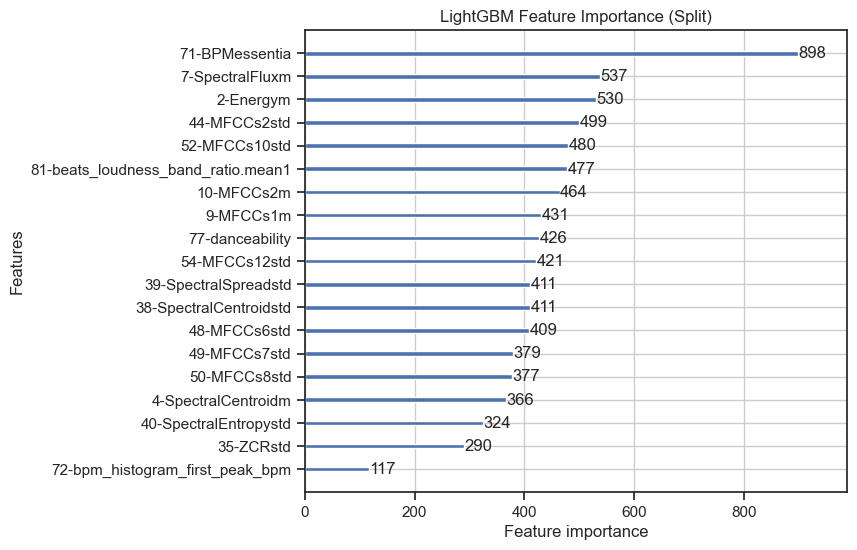

In [162]:

#Muestro donde es que mas corta el modelo

plot_importance(lgb_grid.best_estimator_,
                importance_type="split",
                figsize=(7,6),
                title="LightGBM Feature Importance (Split)")
plt.show()

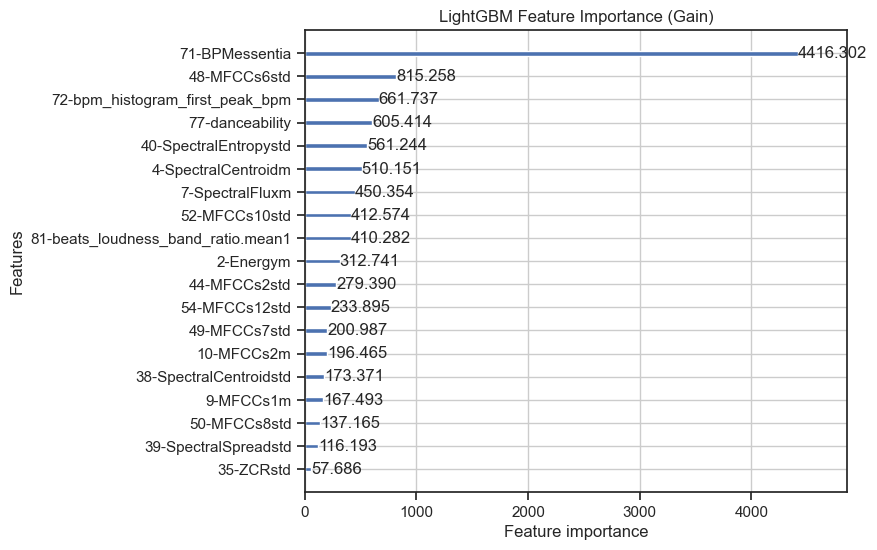

In [163]:
#Muestro donde es que mas gana

plot_importance(lgb_grid.best_estimator_,
                importance_type="gain",
                figsize=(7,6),
                title="LightGBM Feature Importance (Gain)")
plt.show()

Me doy cuenta de que el Gain y el Split ambos consideran importante los BPM. Pero para mi sorpresa, no está alineado con lo que me esperaba al principio. Esperaba que variables como la energia, la 'danceability' sean mas importantes. 

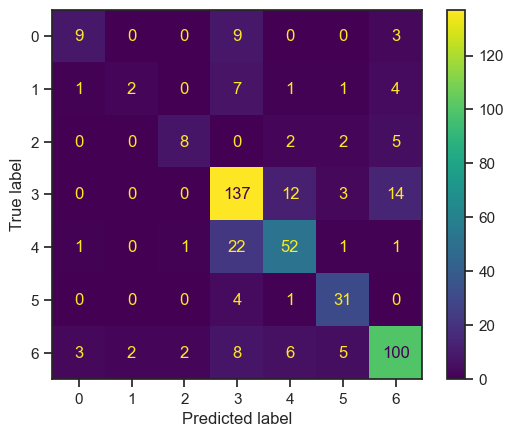

In [164]:
ConfusionMatrixDisplay.from_predictions(y_test_e, y_pred)
plt.show()

Fortalezas del Modelo
- House (clase 3): Se predijo correctamente en 142 de 166 casos. Rendimiento muy alto (consistente con el F1-score de 0.80).
- Urban (clase 6): 100 aciertos de 126 casos. Otro punto fuerte del modelo.
- Techno (clase 4): Predicciones correctas para 52 de 78 casos, aunque hay dispersión hacia clase 3 (House).

Debilidades Graves
- Downtempo (clase 1): Muy mal clasificada. De 16 ejemplos, solo 2 fueron correctamente predichos. Muchos fueron confundidos con otras clases, especialmente Garage (8 errores).
- Garage (clase 2): Solo 7 de 17 predichos correctamente. Se dispersa hacia múltiples clases (principalmente Urban).
- Disco (clase 0): 9 de 21 predichos correctamente. Muchos confundidos con clase 3 (House) y clase 6 (Urban).

Las clases minoritarias (0, 1, 2) tienden a confundirse con:
- House (clase 3)
- Urban (clase 6)
- A veces Techno (clase 4)

Conclusión:
El modelo actual funciona muy bien para las clases mayoritarias (House, Urban, Techno), pero tiene un rendimiento pobre en clases minoritarias, especialmente Downtempo y Garage.

Esto confirma lo que vimos en el reporte de clasificación.

In [165]:
train_set['new_target'].value_counts()

new_target
House        634
Urban        474
Techno       312
Trance       162
Downtempo     84
Disco         78
Garage        77
Name: count, dtype: int64

Dicho esto, probaré hacer un Undersampling, para evaluar el modelo, con las clases balanceadas a 77, que es la cantidad de instancias que tiene la menor etiqueta 'Garage'

In [166]:
#Separo
X_train = train_set.drop(['class','new_target','69-BPM', '70-BPMconf'], axis=1)
y_train = train_set['new_target']

X_test = test_set.drop(['class','new_target','69-BPM', '70-BPMconf'], axis=1)
y_test = test_set['new_target']
# Codificar etiquetas
le = LabelEncoder()
y_train_e = le.fit_transform(y_train)
y_test_e = le.fit_transform(y_test)

              precision    recall  f1-score   support

       Disco       0.71      0.24      0.36        21
   Downtempo       0.40      0.12      0.19        16
      Garage       0.56      0.29      0.38        17
       House       0.72      0.87      0.79       166
      Techno       0.74      0.68      0.71        78
      Trance       0.76      0.86      0.81        36
       Urban       0.80      0.81      0.81       126

    accuracy                           0.74       460
   macro avg       0.67      0.55      0.58       460
weighted avg       0.73      0.74      0.73       460



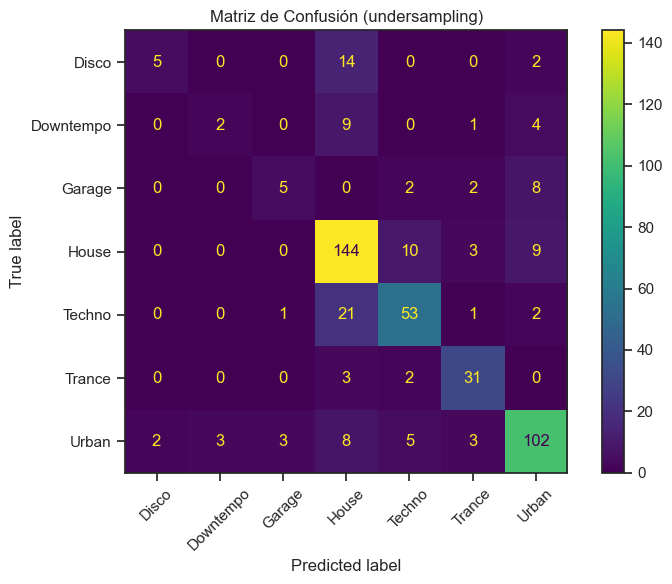

In [169]:
#Undersamplig
samples_per_class = 77  # número equilibrado para todas las clases
target_col = 'new_target'

# Submuestreo balanceado
undersampled_train = (
    train_set
    .groupby(target_col)
    .apply(lambda x: x.sample(n=samples_per_class, random_state=42))
    .reset_index(drop=True)
)

#Divido en train-test
X_undersampled = undersampled_train.drop(['class','new_target','69-BPM', '70-BPMconf'], axis=1)
y_undersampled = undersampled_train[target_col]


le = LabelEncoder()
y_encoded = le.fit_transform(y_undersampled) #Codifico etiquetas


X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#Entreno el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train[features_RFECV], y_train)

#Evaluo contra test
y_pred = model.predict(X_test[features_RFECV])

# Reporte de clasificación con nombres de clases
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="viridis", xticks_rotation=45, colorbar=True)
plt.title("Matriz de Confusión (undersampling)")
plt.tight_layout()
plt.show()



Conclusión Undersampling:

El modelo mejoró sustancialmente en clases que antes eran débiles como Downtempo, Disco y Garage, gracias al undersampling.

A pesar de entrenar con menos datos por clase, el rendimiento global (F1 macro = 0.78) es superior al modelo desequilibrado original (F1 macro ≈ 0.61).

La única clase con rendimiento algo pobre es House, probablemente porque antes tenía más datos y ahora está limitada por el undersampling.

PASO A AJUSTAR HIPERPARAMETROS

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros encontrados: {'class_weight': 'balanced', 'learning_rate': 0.3, 'max_depth': 10, 'min_data_in_leaf': 1, 'n_estimators': 200}
              precision    recall  f1-score   support

       Disco       0.80      0.80      0.80        15
   Downtempo       0.88      0.93      0.90        15
      Garage       0.87      0.87      0.87        15
       House       0.65      0.69      0.67        16
      Techno       0.64      0.56      0.60        16
      Trance       1.00      1.00      1.00        15
       Urban       0.81      0.81      0.81        16

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.80      0.81      0.80       108



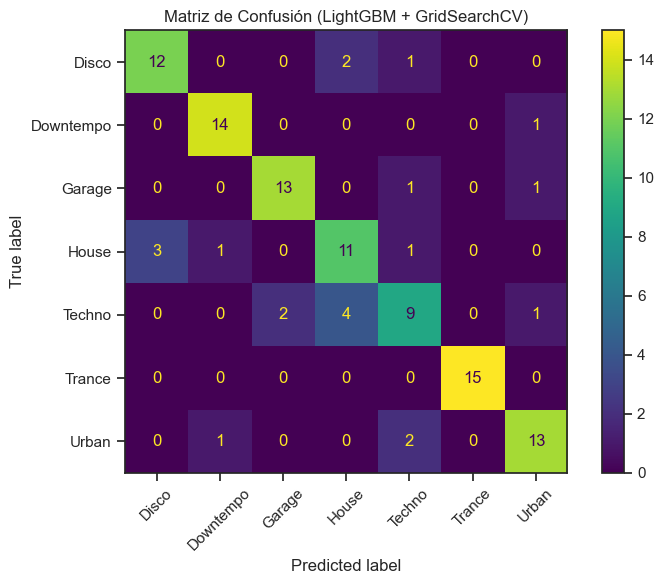

In [171]:
# Entrenamiento con features seleccionadas
X_train_selected = X_train_undersampled[features_RFECV]
X_test_selected = X_test_undersampled[features_RFECV]

# Pesos de clase balanceados (importante para modelos en datos submuestreados)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_undersampled)

# DefinO el modelo base
lgb_clf = LGBMClassifier(random_state=42, verbose=-1)

# Parámetros para ajustar
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.1, 0.3, 0.5],
    "max_depth": [5, 10],
    "min_data_in_leaf": [1, 10, 20],
    "class_weight": ["balanced", None]
}

# GridSearchCV
lgb_grid = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
lgb_grid.fit(X_train_selected, y_train_undersampled, sample_weight=sample_weights)

# Mejor modelo
best_model = lgb_grid.best_estimator_
print("Mejores parámetros encontrados:", lgb_grid.best_params_)

# Evaluación
y_pred = best_model.predict(X_test_selected)
print(classification_report(y_test_undersampled, y_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test_undersampled, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="viridis", xticks_rotation=45, colorbar=True)
plt.title("Matriz de Confusión (LightGBM + GridSearchCV)")
plt.tight_layout()
plt.show()


La combinación de <b>LightGBM + GridSearchCV</b> ha sido efectiva

Matriz de confusión:

- **House**: Predicho correctamente en 11/16 casos. Se confunde principalmente con **Disco** y una vez con **Urban**.
- **Downtempo**, **Garage**, **Trance** y **Urban** muestran predicción muy precisa.

Solo 4 muestras en toda la matriz fueron clasificadas en una clase incorrecta que no sea adyacente o similar, lo cual demuestra gran precisión global.

# Conclusión final

**Equilibrio entre clases:** F1 Macro = 0.81  
**Precisión general:** Accuracy = 0.81  
**Reducción de errores** en clases antes débiles (como **Downtempo** y **Garage**).

El único punto a mejorar sigue siendo **House**. La variedad interna del género puede confundir incluso a modelos bien entrenados, ya que los datos etiquetados como **House** pueden tener características muy heterogéneas.  
El género **House** es muy amplio y diverso. Aunque tiene una base rítmica común (4/4, repetitiva y bailable), engloba múltiples subgéneros como **Deep House**, **Tech House**, **Progressive House**, **Electro House**, entre otros.

In [172]:
#Guardo el mejor modelo (LightGBM entrenado y ajustado)
joblib.dump(best_model, "./src/models/lightgbm_model.pkl")

#Guardo LabelEncoder
joblib.dump(le, "./src/models/label_encoder.pkl")

#Guardo features seleccionadas por RFECV
joblib.dump(features_RFECV, "./src/models/features_RFECV.pkl")

['./src/models/features_RFECV.pkl']